In [28]:
import pandas as pd
import os
import numpy as np
import pytz
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import pytz as tz
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.signal import butter, filtfilt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [29]:
RESPECK_FILE = '../data/bishkek_csr/03_train_ready/respeck/08-05-2025_respeck.csv'
PSG_FILE = '../data/bishkek_csr/03_train_ready/nasal_files/08-05-2025_nasal.csv'
LABELS_FILE = '../data/bishkek_csr/03_train_ready/event_exports/08-05-2025_event_export.csv'
OUTPUT_FILE = './08-05-2025_respeck_features.csv'

# --- Load Data ---
print("Loading data...")

respeck_df = pd.read_csv(RESPECK_FILE)
respeck_df['timestamp'] = pd.to_datetime(respeck_df['alignedTimestamp'], unit='ms')
tz = pytz.timezone('Asia/Bishkek')
respeck_df['timestamp'] = respeck_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(tz)
# respeck_df.set_index('timestamp', inplace=True, drop=False)
print(respeck_df['timestamp'])


psg_df = pd.read_csv(PSG_FILE)
psg_df['timestamp'] = pd.to_datetime(psg_df['UnixTimestamp'], unit='ms')
tz = pytz.timezone('Asia/Bishkek')
psg_df['timestamp'] = psg_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(tz)
print(psg_df['timestamp'])
# psg_df.set_index('timestamp', inplace=True)

labels_df = pd.read_csv(LABELS_FILE)
labels_df['timestamp'] = pd.to_datetime(labels_df['UnixTimestamp'], unit='ms')
tz = pytz.timezone('Asia/Bishkek')
labels_df['timestamp'] = labels_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(tz)
# labels_df.set_index('timestamp', inplace=True)

Loading data...
0        2025-05-08 00:00:58.562000+06:00
1        2025-05-08 00:00:58.642000+06:00
2        2025-05-08 00:00:58.722000+06:00
3        2025-05-08 00:00:58.802000+06:00
4        2025-05-08 00:00:58.882000+06:00
                       ...               
263419   2025-05-08 05:51:48.255000+06:00
263420   2025-05-08 05:51:48.335000+06:00
263421   2025-05-08 05:51:48.415000+06:00
263422   2025-05-08 05:51:48.495000+06:00
263423   2025-05-08 05:51:48.575000+06:00
Name: timestamp, Length: 263424, dtype: datetime64[ns, Asia/Bishkek]
0                2025-05-07 23:58:33+06:00
1         2025-05-07 23:58:33.010000+06:00
2         2025-05-07 23:58:33.020000+06:00
3         2025-05-07 23:58:33.030000+06:00
4         2025-05-07 23:58:33.040000+06:00
                        ...               
2027795   2025-05-08 05:36:30.950000+06:00
2027796   2025-05-08 05:36:30.960000+06:00
2027797   2025-05-08 05:36:30.970000+06:00
2027798   2025-05-08 05:36:30.980000+06:00
2027799   2025-05-08 05

In [30]:
# forward and back fill respeck data before extraction

start_time_respeck = respeck_df['timestamp'].min()
end_time_respeck = respeck_df['timestamp'].max()

start_time_psg = psg_df['timestamp'].min()
end_time_psg = psg_df['timestamp'].max()

overlap_start = max(start_time_respeck, start_time_psg)
overlap_end = min(end_time_respeck, end_time_psg)


print(overlap_start)
print(overlap_end)

respeck_df = respeck_df[(respeck_df['timestamp'] >= overlap_start) & (respeck_df['timestamp'] <= overlap_end)]
psg_df = psg_df[(psg_df['timestamp'] >= overlap_start) & (psg_df['timestamp'] <= overlap_end)]

# Dynamically calculate the sampling rate from the timestamps
time_diffs_ms = respeck_df['alignedTimestamp'].diff().median()
if pd.isna(time_diffs_ms) or time_diffs_ms == 0:

    fs = 1000.0 / time_diffs_ms  # Sampling frequency in Hz
    print(f"    - Calculated sampling rate: {fs:.2f} Hz")

    # Define filter parameters
    lowcut = 0.1   # Lower cutoff frequency in Hz
    highcut = 1.5  # Upper cutoff frequency in Hz
    order = 2      # Filter order (2 is a good choice to avoid distortion)

    try:
        # Design the Butterworth bandpass filter
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        
        respeck_df['original_breathingSignal'] = respeck_df['breathingSignal']

    # 2. Apply the filter and OVERWRITE the 'breathingSignal' column with the clean data
        respeck_df['breathingSignal'] = filtfilt(b, a, respeck_df['breathingSignal'])

        # # Apply the filter and store it in a NEW column
        # # We keep the original 'breathingSignal' for reference
        # respeck_df['filteredBreathingSignal'] = filtfilt(b, a, respeck_df['breathingSignal'])
    except ValueError as e:
        print(f"  - WARNING: Skipping session. Filter could not be applied. Error: {e}")


2025-05-08 00:00:58.562000+06:00
2025-05-08 05:36:30.990000+06:00


In [31]:
# Jack's Util file

def nans(dims):
    a = np.empty(dims)
    a[:] = np.nan
    return a

''' Find the RMS value of an input signal in array form. '''
def rms(signal):
    return np.sqrt(np.mean(signal**2))

def rmsHamming(signal):
    squares = signal**2
    weights = np.hamming(len(signal))
    weightedSum = 0.0
    weightsSum = 0.0

    for i in range(len(signal)):
        weightedSum += squares[i] * weights[i]
        weightsSum += weights[i]

    return np.sqrt(weightedSum / weightsSum)

''' Find islands of defined values in a signal that may contain NaNs. '''
def findIslandLimits(signal, minIslandLength=0, minIslandGap=0):

    islands = []

    start = None
    end = None
    foundIsland = False

    for i in range(len(signal)):
        if not signal[i]:
            if start == None:
                start = i
            else:
                end = i + 1
                if i == len(signal) - 1:
                    foundIsland = True
        else:
            if start != None:
                if end != None:
                    foundIsland = True
                else:
                    start = None

        if foundIsland:
            if (minIslandGap > 0) and (len(islands) > 0):
                prevIslandStart = islands[-1][0]
                prevIslandEnd = islands[-1][1]
                islandGap = start - prevIslandEnd - 1
                if islandGap < minIslandGap:
                    # merge the new island with the previous one
                    islands[-1] = ((prevIslandStart, end))
                else:
                    islands.append((start, end))
            else:    
                islands.append((start, end))

            start = None
            end = None
            foundIsland = False
            
    # now return only the islands that are long enough
    longIslands = []
    for island in islands:
        if (island[1] - island[0]) >= minIslandLength:
            longIslands.append(island)

    return longIslands

def calculateThresholdLevels(signal, rmsBackwardLength, rmsForwardLength, rmsMultiplier, symmetrical):
    result = nans((len(signal), 2))
    
    if not symmetrical:
        
        #fill sum of squares buffers
        posValues = []
        negValues = []
        windowLength = rmsBackwardLength + rmsForwardLength
        if len(signal) < windowLength:
            return result
        
        lastBananaIndex = np.nan
            
        for i in range(windowLength - 1):
            if signal[i] >= 0:
                posValues.append(signal[i])
            elif signal[i] < 0:
                negValues.append(signal[i])
            else: # if nan
                lastBananaIndex = i
                
        posArray = np.array(posValues)
        negArray = np.array(negValues)
        
        sumOfSquaresPos = np.sum(posArray**2)
        posCount = len(posArray)
        sumOfSquaresNeg = np.sum(negArray**2)
        negCount = len(negArray)
        
        for i in range(0, len(signal)):
            if i < rmsBackwardLength or i >= len(signal) - rmsForwardLength:
                posResult = np.nan
                negResult = np.nan
            else:
                newValue = signal[i+rmsForwardLength-1]
                if np.isnan(newValue):
                    lastBananaIndex = i+rmsForwardLength-1
                else:
                    if newValue >= 0:
                        sumOfSquaresPos += newValue**2
                        posCount += 1
                    elif newValue < 0:
                        sumOfSquaresNeg += newValue**2
                        negCount += 1
                
                if not np.isnan(lastBananaIndex) and i - lastBananaIndex <= rmsBackwardLength:
                    posResult = np.nan
                    negResult = np.nan
                else:
                    posResult = np.sqrt(sumOfSquaresPos / posCount) * rmsMultiplier
                    negResult = -np.sqrt(sumOfSquaresNeg / negCount) * rmsMultiplier
                
                oldValue = signal[i-rmsBackwardLength]
                
                if oldValue >= 0:
                    sumOfSquaresPos -= oldValue**2
                    posCount -= 1
                elif oldValue < 0:
                    sumOfSquaresNeg -= oldValue**2
                    negCount -=1
            result[i,0] = posResult
            result[i,1] = negResult
            
        return result
    
    else:
        #fill sum of squares buffers
        allValues = []
        windowLength = rmsBackwardLength + rmsForwardLength
        if len(signal) < windowLength:
            return result
        
        lastBananaIndex = np.nan
        
        for i in range(windowLength - 1):
            if not np.isnan(signal[i]):
                allValues.append(signal[i])
            else:
                lastBananaIndex = i
        allArray = np.array(allValues)
        
        sumOfSquaresAll = np.sum(allArray**2)
        allCount = len(allArray)
        
        for i in range(0, len(signal)):
            if i < rmsBackwardLength or i >= len(signal) - rmsForwardLength:
                allResult = np.nan
            else:
                newValue = signal[i+rmsForwardLength-1]
                if np.isnan(newValue):
                    lastBananaIndex = i+rmsForwardLength-1
                else:
                    sumOfSquaresAll += newValue**2
                    allCount += 1
                
                if not np.isnan(lastBananaIndex) and i - lastBananaIndex <= rmsBackwardLength:
                    allResult = np.nan
                else:
                    allResult = np.sqrt(sumOfSquaresAll / allCount) * rmsMultiplier
                
                oldValue = signal[i-rmsBackwardLength]
                if not np.isnan(oldValue):
                    sumOfSquaresAll -= oldValue**2
                    allCount -= 1
                    
            result[i,0] = allResult
            result[i,1] = -allResult
        #figure()
        #plot(signal)
        #plot(result)
        #show()
        return result

def calculateBreathTimes(signal, posThresholds, negThresholds, minThreshold, zeroCrossingBreathStart):
    
    def breathTimes(startIndex, endIndex):

        def setInitialState(startValue, posThreshold, negThreshold):
            if startValue < negThreshold:
                state = LOW
            elif startValue > posThreshold:
                state = HIGH
            else:
                state = MID_UNKNOWN
            return state
    
        state = setInitialState(signal[startIndex], posThresholds[startIndex], negThresholds[startIndex])
        times = []
    
        for i in range(startIndex + 1, endIndex + 1):
            posThreshold = posThresholds[i]
            negThreshold = negThresholds[i]
            if state == LOW and signal[i] > negThreshold:
                state = MID_RISING
            elif state == HIGH and signal[i] < posThreshold:
                state = MID_FALLING
            elif (state == MID_RISING or state == MID_UNKNOWN) and signal[i] > posThreshold:
                state = HIGH
            elif (state == MID_FALLING or state == MID_UNKNOWN) and signal[i] < negThreshold:
                state = LOW
                times.append(i)

        if zeroCrossingBreathStart:
            zeroCrossingBreathTimes = []
            for t in times:
                for i in range(t,-1,-1):
                    if signal[i] >= 0:
                        zeroCrossingBreathTimes.append(i)
                        break
            return zeroCrossingBreathTimes
        else:
            return times

    LOW, MID_FALLING, MID_UNKNOWN, MID_RISING, HIGH = range(5)

    
    invalidated = np.ones(np.shape(signal), dtype=bool)
    for i in range(len(invalidated)):
        if posThresholds[i] > minThreshold or negThresholds[i] < -minThreshold:
            invalidated[i] = False
    

    minIslandLength = 0
    islandLimits = findIslandLimits(invalidated, minIslandLength)
    
    times = []
    for (start, end) in islandLimits:
        bt = breathTimes(start, end)
        if len(bt) > 0:
            times.append(bt)

    return times


# Code from Jack Taylor

def countLocalMaximas(values):
    count = 0
    if len(values) < 3:
        return 1
    if len(values) > 1 and values[0] > values[1]:
        count += 1
    if len(values) > 1 and values[-1] > values[-2]:
        count += 1
    for i in range(1, len(values) - 1):
        if values[i] > values[i - 1] and values[i] > values[i + 1]:
            count += 1
    return count

def countLocalMinimas(values):
    count = 0
    if len(values) < 3:
        return 1
    if len(values) > 1 and values[0] < values[1]:
        count += 1
    if len(values) > 1 and values[-1] < values[-2]:
        count += 1
    for i in range(1, len(values) - 1):
        if values[i] < values[i - 1] and values[i] < values[i + 1]:
            count += 1
    return count

def generate_RRV(sliced):
    sliced = sliced.dropna()
    if sliced.size == 0:
        return np.nan
    breathingSignal = sliced.values
    N = breathingSignal.shape[-1]
    y = breathingSignal
    yf = np.fft.fft(y)
    yff = 2.0/N * np.abs(yf[:N//2])
    temp_DCnotremov = yff
    if len(temp_DCnotremov) == 0 or len(temp_DCnotremov) == 1: 
        return 0.0
    else:
        DC = np.amax(temp_DCnotremov)
        maxi = np.argmax(temp_DCnotremov)
        temp_DCremov = np.delete(temp_DCnotremov, maxi)
        H1 = np.amax(temp_DCremov)
        return 100-(H1/DC)*100

def getBreaths(df):
    minThreshold = 0.001
    mult = 0.0125
    
    signal = list(df.breathingSignal)
    
    time_diff = df['timestamp'].diff()
    time_diff.map(lambda x: x.total_seconds()).mean()
    
    window_size = int((20 / time_diff.dropna().apply(lambda x: x.total_seconds()).mean()) // 2)
    threshs = calculateThresholdLevels(list(signal), window_size, window_size, mult, False)
    posThresh = threshs[:, 0]
    negThresh = threshs[:, 1]

    times = calculateBreathTimes(list(signal), posThresh, negThresh, minThreshold, False)

    total = set()
    minBreathLength = float("inf")
    maxBreathLength = float("-inf")
    for i in range(0, len(times)):
        vals = times[i]
        for j in range(0, len(vals)-1):
            start, end = vals[j], vals[j+1]
            minBreathLength = min(minBreathLength, end-start+1)
            maxBreathLength = max(maxBreathLength, end-start+1)
            for k in range(start, end+1):
                total.add(k)

    f = list(df.breathingSignal.dropna())
    a = f"Uses Breath From {len(total)}/{len(f)} = {round((len(total)/len(f)) * 100, 2)}% Signal"
    b = f"Max Breath Length: {maxBreathLength} points. Min Breath Length: {minBreathLength} points"
    print(a)
    print(b)
        
    return times


def mode(l):
    if len(l) == 0:
        return np.NaN, {}, []
    
    sortedRoundedArray = np.sort(np.around(l))
    dict = {}
    dist = np.zeros(sortedRoundedArray[-1] + 1)
    maxCount = 0
    for e in sortedRoundedArray:
        dist[e] += 1
        if e in dict:
            newCount = dict[e] + 1
            dict[e] = newCount
        else:
            newCount = 1
            dict[e] = newCount
            
        if newCount > maxCount:
                maxCount = newCount
    
    if maxCount > 0:
        l = []
        for e in dict:
            if dict[e] == maxCount:
                l.append(e)
        sorted = np.sort(l)
        return sorted[len(sorted) // 2], dict, dist
                
    else:
        return np.NaN, dict, dist
    

def extractFeatures(df):
    times = getBreaths(df)

    areas = []
    extremas = []
    peakRespiratoryFlows = []
    types = []
    durations = []
    activityLevels = []
    activityTypes = []
    starts = []
    ends = []
    
    activityLevel = np.array(df.activityLevel)
    activityType = np.array(df.activityType)
    signal = np.array(df.breathingSignal)
    timestamps = list(df.timestamp)

    for i in range(0, len(times)):
        if i % 25 == 0:
            print(f"{i}/{len(times)}... ", end=" ")
        vals = times[i]
        
        for j in range(0, len(vals)-1):
            start, end = vals[j], vals[j+1]
            flag = False
            breath = signal[start:end+1]
            breakPoint = start
            for k, val in enumerate(breath):
                if val >= 0.005: # arbitrary but to remove noise...
                    breakPoint = start + k
                    break

            # compute inhalation
            inhalation, inhalation_times = signal[start:breakPoint], timestamps[start:breakPoint]
            exhalation, exhalation_times = signal[breakPoint:end+1], timestamps[breakPoint:end+1]
                    
            level = activityLevel[start:end+1].mean()
            modeType = mode(activityType[start:end+1])[0]
            
            # compute inhalation
            if len(inhalation) > 1:
                peak = max(abs(np.array(inhalation)))
                extrema = countLocalMaximas(inhalation)
                dx = (inhalation_times[-1]-inhalation_times[0]).total_seconds() / len(inhalation)
                area = abs(np.trapezoid(y=inhalation,dx=dx))
                duration = (inhalation_times[-1]-inhalation_times[0]).total_seconds()
                
                areas.append(area)
                extremas.append(extrema)
                peakRespiratoryFlows.append(peak)
                types.append("Inhalation")
                durations.append(duration)
                activityLevels.append(level)
                activityTypes.append(modeType)
                starts.append(inhalation_times[0])
                ends.append(inhalation_times[-1])

            if len(exhalation) > 1:
                peak = max(abs(np.array(exhalation)))
                extrema = countLocalMinimas(exhalation)    
                dx = (exhalation_times[-1]-exhalation_times[0]).total_seconds() / len(exhalation)
                area = abs(np.trapezoid(y=exhalation,dx=dx))  
                duration = (exhalation_times[-1]-exhalation_times[0]).total_seconds()
                
                areas.append(area)
                extremas.append(extrema)
                peakRespiratoryFlows.append(peak)
                types.append("Exhalation")
                durations.append(duration)
                activityLevels.append(level)
                activityTypes.append(modeType)
                starts.append(exhalation_times[0])
                ends.append(exhalation_times[-1])

    return pd.DataFrame(data={"type": types, "area": areas, "peakRespiratoryFlow": peakRespiratoryFlows, "extremas": extremas, "duration": durations, "meanActivityLevel": activityLevels, "modeActivityType": activityTypes, "startTimestamp": starts, "endTimestamp": ends})


def getRegularity(df):
    # get distance to 1st PC for area, PRF only --> makes rapid shallow in feature level
    # make it temporal by adding distance to PC from all 3 as a seperaate PCA raansform
    scaler = MinMaxScaler()
    columns = ['area', 'peakRespiratoryFlow']
    df_normalized = scaler.fit_transform(df[columns])
    pca = PCA(n_components=1)  
    pca.fit(df_normalized)
    df_pca = pca.transform(df_normalized)
    first_principal_component = pca.components_[0]
    te = np.linalg.norm(df_normalized - np.outer(df_normalized.dot(first_principal_component), first_principal_component), axis=1)

    scaler = MinMaxScaler()
    
    # Okay so we are looking at the resapmled breathing rate
    columns = ['area', 'peakRespiratoryFlow', 'BR_mean']
    df_normalized = scaler.fit_transform(df[columns])
    pca = PCA(n_components=3)  
    pca.fit(df_normalized)
    df_pca = pca.transform(df_normalized)
    
    first_principal_component = pca.components_[0]
    second_principal_component = pca.components_[1]
    third_principal_component = pca.components_[2]
    
    distances_to_first_component = np.linalg.norm(df_normalized - np.outer(df_normalized.dot(first_principal_component), first_principal_component), axis=1)
    distances_to_second_component = np.linalg.norm(df_normalized - np.outer(df_normalized.dot(second_principal_component), second_principal_component), axis=1)
    distances_to_third_component = np.linalg.norm(df_normalized - np.outer(df_normalized.dot(third_principal_component), third_principal_component), axis=1)

    # Linear combination of these distances
    distances_difference = te + (distances_to_first_component - distances_to_second_component + distances_to_third_component)

    distances_difference = (distances_difference - distances_difference.min()) / (distances_difference.max() - distances_difference.min())
    
    return 1 - distances_difference

def combineDfs(respeck_df, original_respeck_df):
    breath_averages = []
    
    original_respeck_df.set_index('timestamp', inplace=True)
    original_respeck_df['BR_md'] = original_respeck_df[['breathingRate']].resample('30s').median().reindex(original_respeck_df.index, method='nearest')
    original_respeck_df['BR_mean'] = original_respeck_df[['breathingRate']].resample('30s').mean().reindex(original_respeck_df.index, method='nearest')
    original_respeck_df['BR_std'] = original_respeck_df[['breathingRate']].resample('30s').std().reindex(original_respeck_df.index, method='nearest')

    original_respeck_df['AL_md'] = original_respeck_df[['activityLevel']].resample('30s').median().reindex(original_respeck_df.index, method='nearest')
    original_respeck_df['AL_mean'] = original_respeck_df[['activityLevel']].resample('30s').mean().reindex(original_respeck_df.index, method='nearest')
    original_respeck_df['AL_std'] = original_respeck_df[['activityLevel']].resample('30s').std().reindex(original_respeck_df.index, method='nearest')


    RRV = original_respeck_df[["breathingSignal"]].resample('30s').apply(generate_RRV)
    RRV = RRV.replace(0, np.nan).ffill().bfill()
    original_respeck_df['RRV'] = RRV.reindex(original_respeck_df.index, method='nearest')

    # average of 3 Neighbours
    RRV3MA = RRV.rolling(window=3, center = True).mean() * 0.65
    original_respeck_df['RRV3MA'] = RRV3MA.reindex(original_respeck_df.index, method='nearest')
    
    original_respeck_df = original_respeck_df.reset_index()
    
    for index, row in respeck_df.iterrows():
        start_timestamp_str = row['startTimestamp']
        end_timestamp_str = row['endTimestamp']

        start_timestamp = pd.to_datetime(start_timestamp_str)
        end_timestamp = pd.to_datetime(end_timestamp_str)

        
        filtered_df = original_respeck_df[
            (original_respeck_df['timestamp'] >= start_timestamp) &
            (original_respeck_df['timestamp'] <= end_timestamp)
        ]
        """
        get sleeping features
        """
        breath_averages.append({
            'type': row['type'],
            'startTimestamp': start_timestamp,
            'endTimestamp': end_timestamp,
            'area': row['area'],
            'extremas': row['extremas'],
            'meanActivityLevel': row['meanActivityLevel'],
            'modeActivityType': row['modeActivityType'],
            'peakRespiratoryFlow': row['peakRespiratoryFlow'],
            'duration': row['duration'],
            'BR_md': filtered_df.BR_md.mean(),
            'BR_mean': filtered_df.BR_mean.mean(),
            'BR_std': filtered_df.BR_std.mean(),
            'AL_md': filtered_df.AL_md.mean(),
            'AL_mean': filtered_df.AL_mean.mean(),
            'AL_std': filtered_df.AL_std.mean(),
            'RRV': filtered_df.RRV.mean(),
            'RRV3MA': filtered_df.RRV3MA.mean(),
        })
    breath_averages_df = pd.DataFrame(breath_averages)
    return breath_averages_df

In [32]:

def calculate_breathing_rate_from_breaths(df, breath_times, window_minutes=1):
    """
    Calculate breathing rate from detected breath times.
    
    Parameters:
    - df: DataFrame with timestamp and breathingSignal columns
    - breath_times: Output from getBreaths function
    - window_minutes: Time window for rate calculation in minutes
    
    Returns:
    - DataFrame with timestamp and calculated breathing rate
    """
    # Convert timestamps to datetime

    df['datetime'] = df['timestamp']
    
    # Flatten all breath indices
    all_breath_indices = []
    for breath_group in breath_times:
        all_breath_indices.extend(breath_group)
    
    # Sort breath indices
    all_breath_indices.sort()
    
    # Create breathing rate time series
    breathing_rates = []
    timestamps = []
    
    # Calculate rate using sliding window
    window_seconds = window_minutes * 60
    
    for i, breath_idx in enumerate(all_breath_indices):
        if breath_idx >= len(df):
            continue
            
        current_time = df.iloc[breath_idx]['datetime']
        timestamps.append(df.iloc[breath_idx]['timestamp'])
        
        # Count breaths in the past window
        breath_count = 0
        for j in range(i, -1, -1):  # Look backwards
            if all_breath_indices[j] >= len(df):
                continue
            breath_time = df.iloc[all_breath_indices[j]]['datetime']
            time_diff = (current_time - breath_time).total_seconds()
            
            if time_diff <= window_seconds:
                breath_count += 1
            else:
                break
        
        # Convert to breaths per minute
        rate = (breath_count / window_seconds) * 60
        breathing_rates.append(rate)
    
    # Create result DataFrame
    result_df = pd.DataFrame({
        'timestamp': timestamps,
        'calculated_breathing_rate': breathing_rates
    })
    
    return result_df

In [34]:
breath_features = extractFeatures(respeck_df)
# Convert 'startTimestamp' to datetime
breath_features['startTimestamp'] = pd.to_datetime(breath_features['startTimestamp'])

# Count the number of breaths (inhalations + exhalations)
breath_features['breath_count'] = 1  # Each row corresponds to a breath

# Total number of breaths
total_breaths = breath_features['breath_count'].sum()

# Get the total duration of the DataFrame in minutes
start_time = breath_features['startTimestamp'].min()
end_time = breath_features['startTimestamp'].max()
total_duration_minutes = (end_time - start_time).total_seconds() / 60  # Convert to minutes

# Calculate average breaths per minute
if total_duration_minutes > 0:
    avg_breaths_per_minute = total_breaths / total_duration_minutes
else:
    avg_breaths_per_minute = 0

print(f'Total Breaths: {total_breaths}')
print(f'Total Duration (minutes): {total_duration_minutes:.2f}')
print(f'Average Breaths per Minute: {avg_breaths_per_minute:.2f}')

Uses Breath From 122628/251385 = 48.78% Signal
Max Breath Length: 133 points. Min Breath Length: 5 points
0/219...  25/219...  50/219...  75/219...  100/219...  125/219...  150/219...  175/219...  200/219...  Total Breaths: 5604
Total Duration (minutes): 335.09
Average Breaths per Minute: 16.72


In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta

def plot_detected_breaths(respeck_df, breath_features, start_minutes=0, duration_minutes=5):
    """
    Plot the breathing signal with detected breaths overlaid.
    
    Parameters:
    - respeck_df: DataFrame with timestamp and breathingSignal
    - breath_features: DataFrame from extractFeatures() with startTimestamp, endTimestamp, type
    - start_minutes: Start time offset in minutes from beginning of data
    - duration_minutes: How many minutes of data to plot
    """
    
    # Convert timestamps to datetime if they aren't already
    respeck_df['timestamp'] = pd.to_datetime(respeck_df['timestamp'])
    breath_features['startTimestamp'] = pd.to_datetime(breath_features['startTimestamp'])
    breath_features['endTimestamp'] = pd.to_datetime(breath_features['endTimestamp'])
    
    # Define the time window to plot
    data_start = respeck_df['timestamp'].min()
    plot_start = data_start + timedelta(minutes=start_minutes)
    plot_end = plot_start + timedelta(minutes=duration_minutes)
    
    # Filter the data for the plotting window
    signal_subset = respeck_df[
        (respeck_df['timestamp'] >= plot_start) & 
        (respeck_df['timestamp'] <= plot_end)
    ].copy()
    
    breaths_subset = breath_features[
        (breath_features['startTimestamp'] >= plot_start) & 
        (breath_features['startTimestamp'] <= plot_end)
    ].copy()
    
    if signal_subset.empty:
        print("No data in the specified time range. Try adjusting start_minutes.")
        return
    
    # Create the plot
    plt.figure(figsize=(15, 8))
    
    # Plot the breathing signal
    plt.plot(signal_subset['timestamp'], signal_subset['breathingSignal'], 
             'b-', linewidth=0.8, label='Breathing Signal', alpha=0.7)
    
    # Plot detected breaths
    colors = {'Inhalation': 'red', 'Exhalation': 'green'}
    markers = {'Inhalation': '^', 'Exhalation': 'v'}
    
    for breath_type in ['Inhalation', 'Exhalation']:
        type_breaths = breaths_subset[breaths_subset['type'] == breath_type]
        if not type_breaths.empty:
            plt.scatter(type_breaths['startTimestamp'], 
                       [signal_subset['breathingSignal'].min() - 0.1] * len(type_breaths),
                       c=colors[breath_type], marker=markers[breath_type], 
                       s=50, label=f'{breath_type} Start', alpha=0.8)
    
    # Add breath duration bars
    for _, breath in breaths_subset.iterrows():
        color = colors[breath['type']]
        plt.axvspan(breath['startTimestamp'], breath['endTimestamp'], 
                   alpha=0.2, color=color)
    
    plt.xlabel('Time')
    plt.ylabel('Breathing Signal Amplitude')
    plt.title(f'Detected Breaths ({duration_minutes} minutes starting at +{start_minutes} min)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print some statistics for this window
    inhalations = breaths_subset[breaths_subset['type'] == 'Inhalation']
    exhalations = breaths_subset[breaths_subset['type'] == 'Exhalation']
    
    print(f"\nStatistics for {duration_minutes}-minute window:")
    print(f"Inhalations detected: {len(inhalations)}")
    print(f"Exhalations detected: {len(exhalations)}")
    print(f"Total breath events: {len(breaths_subset)}")
    print(f"Estimated breathing rate: {(len(inhalations) + len(exhalations)) / duration_minutes:.1f} breaths/minute")


def plot_breath_intervals(breath_features, max_breaths=50):
    """
    Plot the intervals between consecutive breaths to check for regularity.
    """
    # Sort by start timestamp
    breath_features_sorted = breath_features.sort_values('startTimestamp')
    
    # Calculate intervals between consecutive breaths (all types)
    intervals = []
    prev_time = None
    
    for _, breath in breath_features_sorted.head(max_breaths).iterrows():
        current_time = breath['startTimestamp']
        if prev_time is not None:
            interval = (current_time - prev_time).total_seconds()
            intervals.append(interval)
        prev_time = current_time
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(intervals, 'o-', alpha=0.7)
    plt.xlabel('Breath Number')
    plt.ylabel('Interval (seconds)')
    plt.title('Inter-breath Intervals')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.hist(intervals, bins=20, alpha=0.7, edgecolor='black')
    plt.xlabel('Interval (seconds)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Inter-breath Intervals')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Average interval: {np.mean(intervals):.2f} seconds")
    print(f"Standard deviation: {np.std(intervals):.2f} seconds")
    print(f"Estimated breathing rate: {60/np.mean(intervals):.1f} breaths/minute")


def plot_threshold_visualization(respeck_df, start_minutes=0, duration_minutes=2):
    """
    Visualize the adaptive thresholds used by the algorithm.
    """
    # This recreates the threshold calculation from your algorithm
    minThreshold = 0.001
    mult = 0.01
    
    signal = list(respeck_df.breathingSignal)
    
    time_diff = respeck_df['timestamp'].diff()
    window_size = int((10 / time_diff.dropna().apply(lambda x: x.total_seconds()).mean()) // 2)
    
    # Calculate thresholds (using the functions from your code)
    threshs = calculateThresholdLevels(list(signal), window_size, window_size, mult, False)
    posThresh = threshs[:, 0]
    negThresh = threshs[:, 1]
    
    # Define the time window to plot
    data_start = respeck_df['timestamp'].min()
    plot_start = data_start + timedelta(minutes=start_minutes)
    plot_end = plot_start + timedelta(minutes=duration_minutes)
    
    # Get indices for the time window
    start_idx = respeck_df[respeck_df['timestamp'] >= plot_start].index[0]
    end_idx = respeck_df[respeck_df['timestamp'] <= plot_end].index[-1]
    
    # Plot
    plt.figure(figsize=(15, 8))
    
    timestamps = respeck_df.loc[start_idx:end_idx, 'timestamp']
    signal_subset = respeck_df.loc[start_idx:end_idx, 'breathingSignal']
    pos_thresh_subset = posThresh[start_idx:end_idx]
    neg_thresh_subset = negThresh[start_idx:end_idx]
    
    plt.plot(timestamps, signal_subset, 'b-', linewidth=1, label='Breathing Signal')
    plt.plot(timestamps, pos_thresh_subset, 'r--', linewidth=1, label='Positive Threshold', alpha=0.8)
    plt.plot(timestamps, neg_thresh_subset, 'g--', linewidth=1, label='Negative Threshold', alpha=0.8)
    plt.axhline(y=minThreshold, color='orange', linestyle=':', label=f'Min Threshold ({minThreshold})')
    plt.axhline(y=-minThreshold, color='orange', linestyle=':', alpha=0.8)
    
    plt.xlabel('Time')
    plt.ylabel('Signal Amplitude')
    plt.title(f'Breathing Signal with Adaptive Thresholds (mult={mult}, window={window_size})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Usage examples:
# # Plot 5 minutes of data starting from the beginning
# plot_detected_breaths(respeck_df, breath_features, start_minutes=0, duration_minutes=5)

# Plot 5 minutes starting from 30 minutes into the data
plot_detected_breaths(respeck_df, breath_features, start_minutes=30, duration_minutes=5)

# Plot breath intervals
plot_breath_intervals(breath_features)

## OLD Alg

In [91]:
# --- START OF FILE jack-breaths.py ---

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Jack's Util file

def nans(dims):
    a = np.empty(dims)
    a[:] = np.nan
    return a

''' Find the RMS value of an input signal in array form. '''
def rms(signal):
    return np.sqrt(np.mean(signal**2))

def rmsHamming(signal):
    squares = signal**2
    weights = np.hamming(len(signal))
    weightedSum = 0.0
    weightsSum = 0.0

    for i in range(len(signal)):
        weightedSum += squares[i] * weights[i]
        weightsSum += weights[i]

    return np.sqrt(weightedSum / weightsSum)

''' Find islands of defined values in a signal that may contain NaNs. '''
def findIslandLimits(signal, minIslandLength=0, minIslandGap=0):

    islands = []

    start = None
    end = None
    foundIsland = False

    for i in range(len(signal)):
        if not signal[i]:
            if start == None:
                start = i
            else:
                end = i + 1
                if i == len(signal) - 1:
                    foundIsland = True
        else:
            if start != None:
                if end != None:
                    foundIsland = True
                else:
                    start = None

        if foundIsland:
            if (minIslandGap > 0) and (len(islands) > 0):
                prevIslandStart = islands[-1][0]
                prevIslandEnd = islands[-1][1]
                islandGap = start - prevIslandEnd - 1
                if islandGap < minIslandGap:
                    # merge the new island with the previous one
                    islands[-1] = ((prevIslandStart, end))
                else:
                    islands.append((start, end))
            else:
                islands.append((start, end))

            start = None
            end = None
            foundIsland = False
            
    # now return only the islands that are long enough
    longIslands = []
    for island in islands:
        if (island[1] - island[0]) >= minIslandLength:
            longIslands.append(island)

    return longIslands

def calculateThresholdLevels(signal, rmsBackwardLength, rmsForwardLength, rmsMultiplier, symmetrical):
    result = nans((len(signal), 2))
    
    if not symmetrical:
        
        #fill sum of squares buffers
        posValues = []
        negValues = []
        windowLength = rmsBackwardLength + rmsForwardLength
        if len(signal) < windowLength:
            return result
        
        lastBananaIndex = np.nan
            
        for i in range(windowLength - 1):
            if signal[i] >= 0:
                posValues.append(signal[i])
            elif signal[i] < 0:
                negValues.append(signal[i])
            else: # if nan
                lastBananaIndex = i
                
        posArray = np.array(posValues)
        negArray = np.array(negValues)
        
        sumOfSquaresPos = np.sum(posArray**2)
        posCount = len(posArray)
        sumOfSquaresNeg = np.sum(negArray**2)
        negCount = len(negArray)
        
        for i in range(0, len(signal)):
            if i < rmsBackwardLength or i >= len(signal) - rmsForwardLength:
                posResult = np.nan
                negResult = np.nan
            else:
                newValue = signal[i+rmsForwardLength-1]
                if np.isnan(newValue):
                    lastBananaIndex = i+rmsForwardLength-1
                else:
                    if newValue >= 0:
                        sumOfSquaresPos += newValue**2
                        posCount += 1
                    elif newValue < 0:
                        sumOfSquaresNeg += newValue**2
                        negCount += 1
                
                if not np.isnan(lastBananaIndex) and i - lastBananaIndex <= rmsBackwardLength:
                    posResult = np.nan
                    negResult = np.nan
                else:
                    posResult = np.sqrt(sumOfSquaresPos / posCount) * rmsMultiplier if posCount > 0 else np.nan
                    negResult = -np.sqrt(sumOfSquaresNeg / negCount) * rmsMultiplier if negCount > 0 else np.nan

                oldValue = signal[i-rmsBackwardLength]
                
                if oldValue >= 0:
                    sumOfSquaresPos -= oldValue**2
                    posCount -= 1
                elif oldValue < 0:
                    sumOfSquaresNeg -= oldValue**2
                    negCount -=1
            result[i,0] = posResult
            result[i,1] = negResult
            
        return result
    
    else:
        #fill sum of squares buffers
        allValues = []
        windowLength = rmsBackwardLength + rmsForwardLength
        if len(signal) < windowLength:
            return result
        
        lastBananaIndex = np.nan
        
        for i in range(windowLength - 1):
            if not np.isnan(signal[i]):
                allValues.append(signal[i])
            else:
                lastBananaIndex = i
        allArray = np.array(allValues)
        
        sumOfSquaresAll = np.sum(allArray**2)
        allCount = len(allArray)
        
        for i in range(0, len(signal)):
            if i < rmsBackwardLength or i >= len(signal) - rmsForwardLength:
                allResult = np.nan
            else:
                newValue = signal[i+rmsForwardLength-1]
                if np.isnan(newValue):
                    lastBananaIndex = i+rmsForwardLength-1
                else:
                    sumOfSquaresAll += newValue**2
                    allCount += 1
                
                if not np.isnan(lastBananaIndex) and i - lastBananaIndex <= rmsBackwardLength:
                    allResult = np.nan
                else:
                    allResult = np.sqrt(sumOfSquaresAll / allCount) * rmsMultiplier if allCount > 0 else np.nan

                oldValue = signal[i-rmsBackwardLength]
                if not np.isnan(oldValue):
                    sumOfSquaresAll -= oldValue**2
                    allCount -= 1
                    
            result[i,0] = allResult
            result[i,1] = -allResult
        return result

def calculateBreathTimes(signal, posThresholds, negThresholds, minThreshold, zeroCrossingBreathStart):
    
    def breathTimes(startIndex, endIndex):

        def setInitialState(startValue, posThreshold, negThreshold):
            if startValue < negThreshold:
                state = LOW
            elif startValue > posThreshold:
                state = HIGH
            else:
                state = MID_UNKNOWN
            return state
    
        state = setInitialState(signal[startIndex], posThresholds[startIndex], negThresholds[startIndex])
        times = []
    
        for i in range(startIndex + 1, endIndex + 1):
            posThreshold = posThresholds[i]
            negThreshold = negThresholds[i]
            if state == LOW and signal[i] > negThreshold:
                state = MID_RISING
            elif state == HIGH and signal[i] < posThreshold:
                state = MID_FALLING
            elif (state == MID_RISING or state == MID_UNKNOWN) and signal[i] > posThreshold:
                state = HIGH
            elif (state == MID_FALLING or state == MID_UNKNOWN) and signal[i] < negThreshold:
                state = LOW
                times.append(i)

        if zeroCrossingBreathStart:
            zeroCrossingBreathTimes = []
            for t in times:
                for i in range(t,-1,-1):
                    if signal[i] >= 0:
                        zeroCrossingBreathTimes.append(i)
                        break
            return zeroCrossingBreathTimes
        else:
            return times

    LOW, MID_FALLING, MID_UNKNOWN, MID_RISING, HIGH = range(5)

    invalidated = np.ones(np.shape(signal), dtype=bool)
    for i in range(len(invalidated)):
        if posThresholds[i] > minThreshold or negThresholds[i] < -minThreshold:
            invalidated[i] = False
    
    minIslandLength = 0
    islandLimits = findIslandLimits(invalidated, minIslandLength)
    
    times = []
    for (start, end) in islandLimits:
        bt = breathTimes(start, end - 1) # Corrected end index
        if len(bt) > 0:
            times.append(bt)

    return times


# Code from Jack Taylor

def countLocalMaximas(values):
    count = 0
    if len(values) < 3:
        return 1
    if len(values) > 1 and values[0] > values[1]:
        count += 1
    if len(values) > 1 and values[-1] > values[-2]:
        count += 1
    for i in range(1, len(values) - 1):
        if values[i] > values[i - 1] and values[i] > values[i + 1]:
            count += 1
    return count

def countLocalMinimas(values):
    count = 0
    if len(values) < 3:
        return 1
    if len(values) > 1 and values[0] < values[1]:
        count += 1
    if len(values) > 1 and values[-1] < values[-2]:
        count += 1
    for i in range(1, len(values) - 1):
        if values[i] < values[i - 1] and values[i] < values[i + 1]:
            count += 1
    return count

def generate_RRV(sliced):
    sliced = sliced.dropna()
    if sliced.size == 0:
        return np.nan
    breathingSignal = sliced.values
    N = breathingSignal.shape[-1]
    y = breathingSignal
    yf = np.fft.fft(y)
    yff = 2.0/N * np.abs(yf[:N//2])
    temp_DCnotremov = yff
    if len(temp_DCnotremov) == 0 or len(temp_DCnotremov) == 1:
        return 0.0
    else:
        DC = np.amax(temp_DCnotremov)
        maxi = np.argmax(temp_DCnotremov)
        temp_DCremov = np.delete(temp_DCnotremov, maxi)
        H1 = np.amax(temp_DCremov)
        return 100-(H1/DC)*100

def getBreathsConservative(df, return_dataframe=True):
    """
    This function wraps the original breath detection logic and formats the output
    to be compatible with the `compare_breathing_rates_over_time_corrected` testing script.

    Args:
        df (pd.DataFrame): Input dataframe with 'timestamp' and 'breathingSignal'.
        return_dataframe (bool): If True, returns (DataFrame, stats). Otherwise,
                                 returns the raw 'times' list and stats.

    Returns:
        tuple: A tuple containing:
            - breath_df (pd.DataFrame): A DataFrame with 'timestamp' and 'type' for each detected breath event.
            - stats (dict): A dictionary with statistics ('inhalations', 'exhalations', 'breaths_per_minute').
    """
    # Use the core `getBreaths` logic but without the verbose printing
    times = getBreaths(df)

    signal_array = np.array(df.breathingSignal)
    timestamps = list(df.timestamp)
    breath_events = []
    inhalation_count = 0
    exhalation_count = 0

    for island in times:
        for j in range(len(island) - 1):
            start_idx = island[j]
            end_idx = island[j+1]

            if start_idx >= end_idx or end_idx >= len(signal_array):
                continue

            breath_segment = signal_array[start_idx:end_idx+1]
            peak_idx_relative = np.argmax(breath_segment)
            peak_idx = start_idx + peak_idx_relative

            if peak_idx > start_idx:
                inhalation_start_time = timestamps[start_idx]
                breath_events.append({'timestamp': inhalation_start_time, 'type': 'Inhalation'})
                inhalation_count += 1

            if end_idx > peak_idx:
                exhalation_start_time = timestamps[peak_idx]
                breath_events.append({'timestamp': exhalation_start_time, 'type': 'Exhalation'})
                exhalation_count += 1

    if not breath_events:
        breath_df = pd.DataFrame(columns=['timestamp', 'type'])
    else:
        breath_df = pd.DataFrame(breath_events)
        breath_df['timestamp'] = pd.to_datetime(breath_df['timestamp'])

        # ==================== FIX IS HERE ====================
        # The test script expects to localize from UTC. To ensure this works,
        # we strip any existing timezone info, returning a "naive" datetime.
        # The test script will then correctly localize this naive time to UTC.
        if breath_df['timestamp'].dt.tz is not None:
            breath_df['timestamp'] = breath_df['timestamp'].dt.tz_convert('UTC').dt.tz_localize(None)
        # =====================================================

    total_breaths = min(inhalation_count, exhalation_count)
    
    if not df.empty and not df['timestamp'].empty:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        duration_seconds = (df['timestamp'].max() - df['timestamp'].min()).total_seconds()
        duration_minutes = duration_seconds / 60 if duration_seconds > 0 else 0
    else:
        duration_minutes = 0

    breaths_per_minute = total_breaths / duration_minutes if duration_minutes > 0 else 0

    stats = {
        'inhalations': inhalation_count,
        'exhalations': exhalation_count,
        'breaths_per_minute': breaths_per_minute
    }

    if return_dataframe:
        return breath_df, stats
    else:
        return times, stats
# ==============================================================================
# END OF NEW FUNCTION
# ==============================================================================

def mode(l):
    if len(l) == 0:
        return np.NaN, {}, []
    
    # This function expects integer inputs, handle potential floats
    l = [int(x) for x in np.nan_to_num(l)]
    if not l: return np.NaN, {}, []

    sortedRoundedArray = np.sort(l)
    dict = {}
    
    # Handle potentially large integer values gracefully
    dist = {} # Use dict instead of pre-allocating large array
    maxCount = 0
    for e in sortedRoundedArray:
        dist[e] = dist.get(e, 0) + 1
        dict[e] = dict.get(e, 0) + 1
        newCount = dict[e]

        if newCount > maxCount:
                maxCount = newCount
    
    if maxCount > 0:
        l_modes = []
        for e in dict:
            if dict[e] == maxCount:
                l_modes.append(e)
        sorted_modes = np.sort(l_modes)
        # Return the median of the modes
        return sorted_modes[len(sorted_modes) // 2], dict, dist
                
    else:
        return np.NaN, dict, dist

def extractFeatures(df):
    times = getBreaths(df)

    areas = []
    extremas = []
    peakRespiratoryFlows = []
    types = []
    durations = []
    activityLevels = []
    activityTypes = []
    starts = []
    ends = []
    
    activityLevel = np.array(df.activityLevel)
    activityType = np.array(df.activityType)
    signal = np.array(df.breathingSignal)
    timestamps = list(df.timestamp)

    for i in range(0, len(times)):
        if i % 25 == 0 and len(times) > 0:
            print(f"Processing island {i}/{len(times)}... ", end=" ")
        vals = times[i]
        
        for j in range(0, len(vals)-1):
            start, end = vals[j], vals[j+1]
            flag = False
            breath = signal[start:end+1]
            breakPoint = start
            for k, val in enumerate(breath):
                if val >= 0.005: # arbitrary but to remove noise...
                    breakPoint = start + k
                    break

            # compute inhalation
            inhalation, inhalation_times = signal[start:breakPoint], timestamps[start:breakPoint]
            exhalation, exhalation_times = signal[breakPoint:end+1], timestamps[breakPoint:end+1]
                    
            level = activityLevel[start:end+1].mean()
            modeType = mode(activityType[start:end+1])[0]
            
            # compute inhalation
            if len(inhalation) > 1:
                peak = max(abs(np.array(inhalation)))
                extrema = countLocalMaximas(inhalation)
                dx = (inhalation_times[-1]-inhalation_times[0]).total_seconds() / len(inhalation)
                area = abs(np.trapezoid(y=inhalation,dx=dx))
                duration = (inhalation_times[-1]-inhalation_times[0]).total_seconds()
                
                areas.append(area)
                extremas.append(extrema)
                peakRespiratoryFlows.append(peak)
                types.append("Inhalation")
                durations.append(duration)
                activityLevels.append(level)
                activityTypes.append(modeType)
                starts.append(inhalation_times[0])
                ends.append(inhalation_times[-1])

            if len(exhalation) > 1:
                peak = max(abs(np.array(exhalation)))
                extrema = countLocalMinimas(exhalation)    
                dx = (exhalation_times[-1]-exhalation_times[0]).total_seconds() / len(exhalation)
                area = abs(np.trapezoid(y=exhalation,dx=dx))  
                duration = (exhalation_times[-1]-exhalation_times[0]).total_seconds()
                
                areas.append(area)
                extremas.append(extrema)
                peakRespiratoryFlows.append(peak)
                types.append("Exhalation")
                durations.append(duration)
                activityLevels.append(level)
                activityTypes.append(modeType)
                starts.append(exhalation_times[0])
                ends.append(exhalation_times[-1])

    return pd.DataFrame(data={"type": types, "area": areas, "peakRespiratoryFlow": peakRespiratoryFlows, "extremas": extremas, "duration": durations, "meanActivityLevel": activityLevels, "modeActivityType": activityTypes, "startTimestamp": starts, "endTimestamp": ends})


## New Algorithm

In [92]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, detrend, butter, filtfilt
from skimage.filters import threshold_otsu
import warnings



def _consolidate_event_group(event_group):
    """
    Helper function to consolidate a group of consecutive events of the same type.
    """
    if len(event_group) == 1:
        return event_group[0]
    
    # Get basic info from the group
    event_type = event_group[0]['type']
    
    # Use timestamp of the first event (start of the breath phase)
    start_timestamp = event_group[0]['timestamp']
    
    # Use timestamp of the last event (end of the breath phase) 
    end_timestamp = event_group[-1]['timestamp']
    
    # Calculate duration of the consolidated breath phase
    duration_delta = end_timestamp - start_timestamp
    if hasattr(duration_delta, 'total_seconds'):
        duration = duration_delta.total_seconds()
    else:
        # Handle numpy.timedelta64
        duration = duration_delta / np.timedelta64(1, 's')
    
    # For amplitude, use the maximum as it represents the peak of the breath phase
    amplitudes = [event['amplitude'] for event in event_group]
    raw_amplitudes = [event['raw_amplitude'] for event in event_group]
    
    max_amplitude_idx = np.argmax([abs(amp) for amp in amplitudes])
    consolidated_amplitude = amplitudes[max_amplitude_idx]
    consolidated_raw_amplitude = raw_amplitudes[max_amplitude_idx]
    
    # Use index from the event with maximum amplitude
    consolidated_index = event_group[max_amplitude_idx]['index']
    
    # Create consolidated event
    consolidated_event = {
        'type': event_type,
        'index': consolidated_index,
        'timestamp': start_timestamp,
        'end_timestamp': end_timestamp,
        'duration_seconds': duration,
        'amplitude': consolidated_amplitude,
        'raw_amplitude': consolidated_raw_amplitude,
        'event_type': event_group[0]['event_type'],
        'orientation_type': event_group[0]['orientation_type'],
        'gravity_influence': event_group[0]['gravity_influence'],
        'events_merged': len(event_group),
        'is_consolidated': True
    }
    
    return consolidated_event

def _calibrate_orientation_thresholds_with_accelerometer(signal, sampling_rate, accel_x, accel_y, accel_z, fallback_low=0.15, fallback_high=0.5):
    """
    Enhanced version that combines Otsu's method on breathing signal DC offset
    with accelerometer data for more accurate orientation classification.
    
    Parameters:
    - signal: Breathing signal array
    - sampling_rate: Sampling rate in Hz
    - accel_x, accel_y, accel_z: Accelerometer data arrays (same length as signal)
    - fallback_low, fallback_high: Fallback thresholds if calibration fails
    
    Returns:
    - (low_threshold, high_threshold): Enhanced orientation thresholds
    - orientation_info: Dictionary with accelerometer analysis
    """
    
    print("🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA")
    print("=" * 55)
    
    try:
        # === STEP 1: Original Otsu method on breathing signal ===
        window_len = int(15 * sampling_rate)
        if len(signal) < window_len * 2:
            raise ValueError("Signal too short for robust calibration.")
        
        # Calculate DC offset using moving average
        dc_series = np.convolve(signal, np.ones(window_len) / window_len, mode='valid')
        abs_dc_series = np.abs(dc_series)
        
        if np.std(abs_dc_series) < 1e-4:
            raise ValueError("No significant change in DC offset.")
        
        # Apply Otsu's method to breathing signal
        scaler = 10000
        scaled_data = (abs_dc_series * scaler).astype(int)
        otsu_threshold_scaled = threshold_otsu(scaled_data)
        otsu_threshold = otsu_threshold_scaled / scaler
        
        print(f"✅ Otsu threshold from breathing signal: {otsu_threshold:.4f}")
        
        # === STEP 2: Analyze accelerometer data ===
        print(f"\n📊 ACCELEROMETER ANALYSIS:")
        
        # Calculate gravity vector magnitude and dominant axis
        gravity_magnitude = np.sqrt(accel_x**2 + accel_y**2 + accel_z**2)
        avg_gravity = np.mean(gravity_magnitude)
        
        # Smooth accelerometer data for orientation analysis
        smooth_window = min(window_len, len(accel_x) // 10)
        if smooth_window > 5:
            from scipy.signal import savgol_filter
            if smooth_window % 2 == 0:
                smooth_window += 1
            accel_x_smooth = savgol_filter(accel_x, smooth_window, 3)
            accel_y_smooth = savgol_filter(accel_y, smooth_window, 3)
            accel_z_smooth = savgol_filter(accel_z, smooth_window, 3)
        else:
            accel_x_smooth = accel_x
            accel_y_smooth = accel_y
            accel_z_smooth = accel_z
        
        # Calculate average orientations
        avg_x = np.mean(accel_x_smooth)
        avg_y = np.mean(accel_y_smooth)
        avg_z = np.mean(accel_z_smooth)
        
        print(f"Average gravity magnitude: {avg_gravity:.3f}g")
        print(f"Average orientation: [{avg_x:.3f}, {avg_y:.3f}, {avg_z:.3f}]")
        
        # === STEP 3: Classify body orientation using accelerometer ===
        abs_x, abs_y, abs_z = abs(avg_x), abs(avg_y), abs(avg_z)
        
        if abs_z > 0.8:  # Lying flat
            if avg_z < -0.8:
                orientation_type = "supine"  # Back (sensor facing up)
                gravity_influence = "high"
            elif avg_z > 0.8:
                orientation_type = "prone"   # Stomach (sensor facing down) 
                gravity_influence = "high"
            else:
                orientation_type = "mixed"
                gravity_influence = "medium"
        elif abs_x > 0.6:  # Side lying
            if avg_x < -0.6:
                orientation_type = "left_side"
            else:
                orientation_type = "right_side"
            gravity_influence = "medium"
        else:
            orientation_type = "mixed"
            gravity_influence = "low"
        
        print(f"Detected orientation: {orientation_type}")
        print(f"Gravity influence: {gravity_influence}")
        
        # === STEP 4: Adjust Otsu thresholds based on accelerometer orientation ===
        if gravity_influence == "high":
            # Strong gravity effects - need higher thresholds and filtering
            threshold_multiplier = 1.5
            low_threshold = otsu_threshold * threshold_multiplier
            high_threshold = low_threshold + 0.1
            preprocessing_needed = "high_pass_filter"
            
        elif gravity_influence == "medium": 
            # Moderate gravity effects - use Otsu threshold as-is
            threshold_multiplier = 1.0
            low_threshold = otsu_threshold
            high_threshold = low_threshold + 0.05
            preprocessing_needed = "detrend_only"
            
        else:  # gravity_influence == "low"
            # Minimal gravity effects - can use lower thresholds
            threshold_multiplier = 0.8
            low_threshold = otsu_threshold * threshold_multiplier
            high_threshold = low_threshold + 0.03
            preprocessing_needed = "minimal"
        
        # Sanity checks
        if low_threshold >= high_threshold or high_threshold > 2.0 or low_threshold < 0.01:
            raise ValueError("Calibrated thresholds are not plausible.")
        
        print(f"\n✅ ENHANCED CALIBRATION RESULTS:")
        print(f"Orientation-adjusted low threshold: {low_threshold:.4f}")
        print(f"Orientation-adjusted high threshold: {high_threshold:.4f}")
        print(f"Recommended preprocessing: {preprocessing_needed}")
        
        # Create orientation info dictionary
        orientation_info = {
            'orientation_type': orientation_type,
            'gravity_influence': gravity_influence,
            'avg_orientation': [avg_x, avg_y, avg_z],
            'avg_gravity_magnitude': avg_gravity,
            'otsu_threshold_original': otsu_threshold,
            'threshold_multiplier': threshold_multiplier,
            'preprocessing_needed': preprocessing_needed
        }
        
        return (low_threshold, high_threshold), orientation_info
        
    except Exception as e:
        print(f"⚠️  Enhanced calibration failed ({e}). Using fallback thresholds.")
        
        # Fallback orientation analysis
        if len(accel_x) > 0:
            avg_x = np.mean(accel_x)
            avg_z = np.mean(accel_z)
            if abs(avg_z) > 0.7:
                orientation_type = "supine" if avg_z < 0 else "prone"
                gravity_influence = "high"
            else:
                orientation_type = "side"
                gravity_influence = "medium"
        else:
            orientation_type = "unknown"
            gravity_influence = "medium"
        
        orientation_info = {
            'orientation_type': orientation_type,
            'gravity_influence': gravity_influence,
            'avg_orientation': [0, 0, -1],
            'preprocessing_needed': 'detrend_only',
            'fallback_used': True
        }
        
        return (fallback_low, fallback_high), orientation_info


def _consolidate_event_group(event_group):
    """
    Helper function to consolidate a group of consecutive events of the same type.
    """
    if len(event_group) == 1:
        return event_group[0]
    
    # Get basic info from the group
    event_type = event_group[0]['type']
    
    # Use timestamp of the first event (start of the breath phase)
    start_timestamp = event_group[0]['timestamp']
    
    # Use timestamp of the last event (end of the breath phase) 
    end_timestamp = event_group[-1]['timestamp']
    
    # Calculate duration of the consolidated breath phase
    duration_delta = end_timestamp - start_timestamp
    if hasattr(duration_delta, 'total_seconds'):
        duration = duration_delta.total_seconds()
    else:
        # Handle numpy.timedelta64
        duration = duration_delta / np.timedelta64(1, 's')
    
    # For amplitude, use the maximum as it represents the peak of the breath phase
    amplitudes = [event['amplitude'] for event in event_group]
    raw_amplitudes = [event['raw_amplitude'] for event in event_group]
    
    max_amplitude_idx = np.argmax([abs(amp) for amp in amplitudes])
    consolidated_amplitude = amplitudes[max_amplitude_idx]
    consolidated_raw_amplitude = raw_amplitudes[max_amplitude_idx]
    
    # Use index from the event with maximum amplitude
    consolidated_index = event_group[max_amplitude_idx]['index']
    
    # Create consolidated event
    consolidated_event = {
        'type': event_type,
        'index': consolidated_index,
        'timestamp': start_timestamp,
        'end_timestamp': end_timestamp,
        'duration_seconds': duration,
        'amplitude': consolidated_amplitude,
        'raw_amplitude': consolidated_raw_amplitude,
        'event_type': event_group[0]['event_type'],
        'orientation_type': event_group[0]['orientation_type'],
        'gravity_influence': event_group[0]['gravity_influence'],
        'events_merged': len(event_group),
        'is_consolidated': True
    }
    
    return consolidated_event

def _detect_high_breathing_rate_periods(signal, sampling_rate, window_minutes=2):
    """
    Detect periods likely to have high breathing rates that need special handling.
    """
    window_samples = int(window_minutes * 60 * sampling_rate)
    high_rate_mask = np.zeros(len(signal), dtype=bool)
    
    # Slide window to detect high-frequency content
    step_size = window_samples // 4
    for i in range(0, len(signal) - window_samples, step_size):
        window_signal = signal[i:i + window_samples]
        
        # Quick peak count estimate
        detrended = detrend(window_signal, type='constant')
        rough_peaks, _ = find_peaks(np.abs(detrended), distance=int(0.8 * sampling_rate))  # Min 0.8s apart
        
        estimated_rate = len(rough_peaks) * (60 / window_minutes)  # Convert to per-minute
        
        # If estimated rate > 20 breaths/min, mark as high-rate period
        if estimated_rate > 20:
            high_rate_mask[i:i + window_samples] = True
    
    return high_rate_mask

def adaptive_breath_detection_clean_padding(df, adaptation_window_minutes=10, 
                                           sensitivity='medium', method='peaks',
                                           pad_duration_minutes=20):
    """
    Clean padding approach: Only pad data arrays, use index arithmetic to map back to original timeline.
    No timestamp manipulation or trimming needed!
    """
    
    print("🚀 CLEAN PADDING APPROACH (INDEX ARITHMETIC)")
    print("=" * 75)
    
    # --- Input validation and data preparation ---
    required_columns = ['breathingSignal', 'timestamp']
    accelerometer_columns = ['x', 'y', 'z']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain columns: {required_columns}")
    
    signal_series = df['breathingSignal'].copy().replace([np.inf, -np.inf], np.nan)
    valid_signal = signal_series.dropna()
    if len(valid_signal) < 200:
        raise ValueError(f"Insufficient valid samples: {len(valid_signal)}")
    
    # Keep original arrays UNCHANGED
    original_signal = valid_signal.values
    valid_indices = valid_signal.index
    original_timestamps = df.loc[valid_indices, 'timestamp'].values
    original_accel_x = df.loc[valid_indices, 'x'].values
    original_accel_y = df.loc[valid_indices, 'y'].values
    original_accel_z = df.loc[valid_indices, 'z'].values
    activity_level = df.loc[valid_indices, 'activityLevel'].values if 'activityLevel' in df.columns else None
    
    # Calculate sampling rate
    time_diffs = pd.Series(original_timestamps).diff().dropna()
    avg_sample_period = time_diffs.apply(lambda x: x.total_seconds()).median()
    if pd.isna(avg_sample_period) or avg_sample_period <= 0:
        avg_sample_period = 0.02
    sampling_rate = 1 / avg_sample_period
    
    print(f"📊 Original data: {len(valid_signal):,} samples at {sampling_rate:.1f} Hz")
    
    # --- CLEAN PADDING: Only pad data arrays using numpy's built-in padding ---
    pad_samples = int(pad_duration_minutes * 60 * sampling_rate)
    
    print(f"🔧 Applying clean padding ({pad_duration_minutes} minutes = {pad_samples:,} samples)...")
    
    # Pad only the data arrays - timestamps stay original!
    signal_padded = np.pad(original_signal, pad_samples, mode='reflect')
    accel_x_padded = np.pad(original_accel_x, pad_samples, mode='reflect')
    accel_y_padded = np.pad(original_accel_y, pad_samples, mode='reflect')
    accel_z_padded = np.pad(original_accel_z, pad_samples, mode='reflect')
    
    if activity_level is not None:
        activity_padded = np.pad(activity_level, pad_samples, mode='edge')  # Use edge mode for activity
    else:
        activity_padded = None
    
    print(f"✅ Padded signal: {len(signal_padded):,} samples (added {2*pad_samples:,} samples)")
    
    # --- Detect high breathing rate periods on padded signal ---
    print(f"🔍 Detecting high breathing rate periods...")
    high_rate_mask = _detect_high_breathing_rate_periods(signal_padded, sampling_rate)
    high_rate_ratio = np.mean(high_rate_mask)
    print(f"   Identified {high_rate_ratio:.1%} of padded signal as potential high-rate periods")
    
    # --- Run algorithm on padded data ---
    adaptation_window_samples = int(adaptation_window_minutes * 60 * sampling_rate)
    adaptation_window_samples = min(adaptation_window_samples, len(signal_padded) // 2)
    
    sensitivity_params = {
        'low': {'base_height': 0.6, 'base_prominence': 0.5},
        'medium': {'base_height': 0.5, 'base_prominence': 0.4},
        'high': {'base_height': 0.4, 'base_prominence': 0.3}
    }
    params = sensitivity_params.get(sensitivity, sensitivity_params['medium'])
    all_breath_events = []
    step_size = adaptation_window_samples // 4
    window_start = 0
    
    while window_start + adaptation_window_samples <= len(signal_padded):
        window_end = window_start + adaptation_window_samples
        
        # Extract window from padded data
        window_signal = signal_padded[window_start:window_end]
        window_accel_x = accel_x_padded[window_start:window_end]
        window_accel_y = accel_y_padded[window_start:window_end]
        window_accel_z = accel_z_padded[window_start:window_end]
        window_high_rate_mask = high_rate_mask[window_start:window_end]
        
        # Check if this window contains high breathing rate periods
        window_high_rate_ratio = np.mean(window_high_rate_mask)
        is_high_rate_window = window_high_rate_ratio > 0.3  # >30% of window is high-rate
        
        if is_high_rate_window:
            print(f"\n-- HIGH-RATE window at padded index {window_start} ({window_high_rate_ratio:.1%} high-rate) --")
        
        # Get orientation info for this window
        try:
            (_, _), window_orientation_info = _calibrate_orientation_thresholds_with_accelerometer(
                window_signal, sampling_rate, window_accel_x, window_accel_y, window_accel_z
            )
        except:
            window_orientation_info = {'orientation_type': 'unknown', 'gravity_influence': 'medium'}
        
        # Apply all the targeted fixes
        detrended_signal = detrend(window_signal, type='constant')
        signal_std = np.std(detrended_signal)
        signal_mad = np.median(np.abs(detrended_signal - np.median(detrended_signal)))
        
        if signal_mad > 0 and signal_std / signal_mad > 3.0:
            robust_std = signal_mad * 1.4826
            signal_std = min(signal_std, robust_std * 2)
        
        gravity_influence = window_orientation_info['gravity_influence']
        
        if gravity_influence == 'high':
            min_amplitude, base_height_factor, base_prominence_factor = 0.015, 0.25, 0.2
        elif gravity_influence == 'medium':
            min_amplitude, base_height_factor, base_prominence_factor = 0.008, 0.15, 0.12
        else:
            min_amplitude, base_height_factor, base_prominence_factor = 0.005, 0.1, 0.08
        
        # Special adjustments for high breathing rate periods
        if is_high_rate_window:
            base_height_factor *= 0.6      # Lower thresholds
            base_prominence_factor *= 0.6  # Lower prominence requirements
            min_amplitude *= 0.7           # Lower minimum amplitude
        
        # Activity factor calculation
        activity_factor = 1.0
        if activity_padded is not None:
            window_activity = activity_padded[window_start:window_end]
            avg_activity = np.mean(window_activity)
            
            if is_high_rate_window:
                # During high-rate periods, be less aggressive with activity penalties
                if avg_activity > 0.1: 
                    activity_factor = min(1.15, 1.0 + avg_activity)
                else:
                    activity_factor = 0.9
            else:
                # Normal activity handling
                if avg_activity > 0.1: 
                    activity_factor = min(1.3, 1.0 + avg_activity * 2)
                elif avg_activity > 0.03: 
                    activity_factor = 1.0
                else: 
                    activity_factor = 0.8
        
        # Calculate thresholds
        noise_estimate = np.std(np.diff(detrended_signal)) * np.sqrt(2)
        snr = signal_std / (noise_estimate + 1e-10)
        quality_factor = 1.4 if snr < 2 else 1.0 if snr < 4 else 0.8
        
        sleep_factor = 0.9
        combined_factor = (sleep_factor * activity_factor * quality_factor * params['base_height'] * base_height_factor)
        
        height_threshold = max(signal_std * combined_factor, min_amplitude * 0.3)
        max_reasonable_threshold = np.percentile(np.abs(detrended_signal), 75) * 0.5
        height_threshold = min(height_threshold, max_reasonable_threshold)
        
        prominence_threshold = max(signal_std * combined_factor * 0.8, min_amplitude * 0.15)
        prominence_threshold = min(prominence_threshold, max_reasonable_threshold * 0.8)
        
        # Adaptive minimum distance
        if is_high_rate_window:
            base_distance_sec = 0.8  # Much shorter for fast breathing
        else:
            base_distance_sec = 1.8 if gravity_influence == 'high' else 1.2 if gravity_influence == 'low' else 1.5
        
        signal_peaks_rough, _ = find_peaks(np.abs(detrended_signal), distance=int(0.5 * sampling_rate))
        if len(signal_peaks_rough) > len(detrended_signal) / (sampling_rate * 2):
            base_distance_sec *= 0.7
        
        min_distance = max(3, int(base_distance_sec * sampling_rate))
        
        # Signal preprocessing
        processed_signal = detrend(window_signal, type='constant')
        preprocessing_needed = window_orientation_info.get('preprocessing_needed', 'detrend_only')
        if preprocessing_needed == 'high_pass_filter':
            try:
                b, a = butter(2, 0.05 / (sampling_rate / 2), btype='high')
                processed_signal = filtfilt(b, a, processed_signal)
            except Exception: 
                pass
        
        # Peak detection with dual-pass
        try:
            peaks, _ = find_peaks(processed_signal, height=height_threshold, distance=min_distance, prominence=prominence_threshold, width=2)
            troughs, _ = find_peaks(-processed_signal, height=height_threshold, distance=min_distance, prominence=prominence_threshold, width=2)
            
            total_events_found = len(peaks) + len(troughs)
            
            # Adaptive expected minimum events
            if is_high_rate_window:
                expected_min_events = len(processed_signal) / (sampling_rate * 2.5)  # Expect more events
            else:
                expected_min_events = len(processed_signal) / (sampling_rate * 4)
            
            # Relaxed detection if needed
            if total_events_found < expected_min_events:
                if is_high_rate_window:
                    relaxed_height = height_threshold * 0.5
                    relaxed_prominence = prominence_threshold * 0.5
                    relaxed_distance = max(2, int(min_distance * 0.6))
                else:
                    relaxed_height = height_threshold * 0.7
                    relaxed_prominence = prominence_threshold * 0.7
                    relaxed_distance = max(3, int(min_distance * 0.8))
                
                peaks_relaxed, _ = find_peaks(processed_signal, height=relaxed_height, distance=relaxed_distance, prominence=relaxed_prominence, width=1)
                troughs_relaxed, _ = find_peaks(-processed_signal, height=relaxed_height, distance=relaxed_distance, prominence=relaxed_prominence, width=1)
                
                if len(peaks_relaxed) + len(troughs_relaxed) > total_events_found * 1.3:
                    peaks, troughs = peaks_relaxed, troughs_relaxed
            
            # --- KEY IMPROVEMENT: Index arithmetic to map back to original timeline ---
            validation_multiplier = 0.5 if is_high_rate_window else 0.75
            
            for peak_idx in [p for p in peaks if processed_signal[p] > height_threshold * validation_multiplier]:
                # Get index relative to the start of the PADDED signal
                global_padded_idx = window_start + peak_idx
                
                # === CONVERT TO ORIGINAL INDEX ===
                original_signal_idx = global_padded_idx - pad_samples
                
                # Only add event if it falls within the original data range
                if 0 <= original_signal_idx < len(original_timestamps):
                    all_breath_events.append({
                        'type': 'Inhalation',
                        # Use original index to get correct timestamp and valid_index
                        'index': valid_indices[original_signal_idx],
                        'timestamp': original_timestamps[original_signal_idx],
                        'amplitude': processed_signal[peak_idx], 
                        'raw_amplitude': original_signal[original_signal_idx],  # Use original signal value
                        'event_type': 'peak', 
                        'orientation_type': window_orientation_info['orientation_type'],
                        'gravity_influence': gravity_influence, 
                        'high_rate_period': is_high_rate_window
                    })
            
            for trough_idx in [t for t in troughs if abs(processed_signal[t]) > height_threshold * validation_multiplier]:
                global_padded_idx = window_start + trough_idx
                original_signal_idx = global_padded_idx - pad_samples
                
                if 0 <= original_signal_idx < len(original_timestamps):
                    all_breath_events.append({
                        'type': 'Exhalation',
                        'index': valid_indices[original_signal_idx],
                        'timestamp': original_timestamps[original_signal_idx],
                        'amplitude': processed_signal[trough_idx], 
                        'raw_amplitude': original_signal[original_signal_idx],
                        'event_type': 'trough', 
                        'orientation_type': window_orientation_info['orientation_type'],
                        'gravity_influence': gravity_influence, 
                        'high_rate_period': is_high_rate_window
                    })
                    
        except Exception as e:
            pass
        
        window_start += step_size
    
    # --- NO TRIMMING STEP NEEDED! All events are already in original range ---
    print(f"✅ Detected {len(all_breath_events)} events (all automatically within original time range)")
    
    # --- Rest of processing (same as before) ---
    if not all_breath_events:
        return pd.DataFrame(), {'error': 'No events detected'}
    
    all_breath_events.sort(key=lambda x: x['timestamp'])
    
    # Filter and consolidate
    filtered_events = []
    last_timestamp = None
    min_event_spacing = pd.Timedelta(seconds=0.5)
    for event in all_breath_events:
        if last_timestamp is None or (pd.Timestamp(event['timestamp']) - last_timestamp) > min_event_spacing:
            filtered_events.append(event)
            last_timestamp = pd.Timestamp(event['timestamp'])
    
    # Consolidation
    consolidated_events = []
    current_group = []
    for event in filtered_events:
        if not current_group or current_group[-1]['type'] == event['type']:
            current_group.append(event)
        else:
            consolidated_events.append(_consolidate_event_group(current_group))
            current_group = [event]
    if current_group:
        consolidated_events.append(_consolidate_event_group(current_group))
    
    breath_df = pd.DataFrame(consolidated_events).sort_values('timestamp').reset_index(drop=True)
    
    # Final statistics
    total_events = len(consolidated_events)
    inhalations = len([e for e in consolidated_events if e['type'] == 'Inhalation'])
    exhalations = len([e for e in consolidated_events if e['type'] == 'Exhalation'])
    breathing_cycles = min(inhalations, exhalations)
    high_rate_events = len([e for e in consolidated_events if e.get('high_rate_period', False)])
    
    duration_minutes = (pd.Timestamp(original_timestamps[-1]) - pd.Timestamp(original_timestamps[0])).total_seconds() / 60 if len(original_timestamps) > 1 else 0
    if duration_minutes <= 0: 
        duration_minutes = len(original_timestamps) * avg_sample_period / 60
    breaths_per_minute = breathing_cycles / duration_minutes if duration_minutes > 0 else 0
    
    stats = {
        'total_events': total_events, 'breathing_cycles': breathing_cycles,
        'breaths_per_minute': breaths_per_minute, 'duration_minutes': duration_minutes,
        'inhalations': inhalations, 'exhalations': exhalations,
        'high_rate_events': high_rate_events, 'high_rate_percentage': high_rate_events / total_events * 100 if total_events > 0 else 0,
        'method': method, 'sensitivity': sensitivity, 'sampling_rate': sampling_rate,
        'adaptation_window_minutes': adaptation_window_minutes,
        'pad_duration_minutes': pad_duration_minutes, 'error': None
    }
    
    print(f"\n✅ CLEAN PADDING APPROACH COMPLETE:")
    print(f"Detected {total_events:,} consolidated breath events ({breathing_cycles:,} cycles)")
    print(f"High-rate period events: {high_rate_events} ({high_rate_events/total_events*100:.1f}%)")
    print(f"Final breathing rate: {breaths_per_minute:.1f} breaths/min")
    
    return breath_df, stats

## Comparisons

In [89]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns

def compare_algorithms_vs_respeck_builtin(respeck_df, window_minutes=5):
    """
    Compare both new and old algorithms against RESpeck's built-in breathing rate measurements
    using 5-minute non-overlapping windows.
    """
    
    print("🔍 ALGORITHMS vs RESpeck BUILT-IN BREATHING RATE COMPARISON")
    print("=" * 80)
    print(f"📅 Using {window_minutes}-minute non-overlapping windows")
    
    # --- 1. Check RESpeck built-in breathing rate data ---
    if 'breathingRate' not in respeck_df.columns:
        print("❌ No 'breathingRate' column found in RESpeck data")
        return None
    
    respeck_sensor_data = respeck_df[['timestamp', 'breathingRate']].copy()
    respeck_sensor_data['breathingRate'] = pd.to_numeric(respeck_sensor_data['breathingRate'], errors='coerce')
    
    # Only keep valid breathing rate measurements
    valid_respeck = respeck_sensor_data.dropna(subset=['breathingRate'])
    
    if valid_respeck.empty:
        print("❌ No valid RESpeck breathing rate data available")
        return None
    
    print(f"✅ Found {len(valid_respeck):,} valid RESpeck measurements")
    print(f"   Time range: {valid_respeck['timestamp'].min()} to {valid_respeck['timestamp'].max()}")
    print(f"   Rate range: {valid_respeck['breathingRate'].min():.1f} - {valid_respeck['breathingRate'].max():.1f} breaths/min")
    
    # --- 2. Determine time windows ---
    data_start = respeck_df['timestamp'].min()
    data_end = respeck_df['timestamp'].max()
    
    total_duration = (data_end - data_start).total_seconds() / 60  # minutes
    num_windows = int(total_duration // window_minutes)
    
    print(f"\n📊 Dataset Overview:")
    print(f"   Data range: {data_start} to {data_end}")
    print(f"   Total duration: {total_duration:.1f} minutes")
    print(f"   Number of {window_minutes}-min windows: {num_windows}")
    
    if num_windows < 1:
        print(f"❌ Insufficient data for {window_minutes}-minute windows")
        return None
    
    # --- 3. Process each window ---
    results = []
    
    for i in range(num_windows):
        window_start = data_start + pd.Timedelta(minutes=i * window_minutes)
        window_end = window_start + pd.Timedelta(minutes=window_minutes)
        
        print(f"\n--- Window {i+1}/{num_windows}: {window_start.strftime('%H:%M')} to {window_end.strftime('%H:%M')} ---")
        
        # Extract data for this window
        respeck_window = respeck_df[(respeck_df['timestamp'] >= window_start) & 
                                   (respeck_df['timestamp'] < window_end)].copy()
        
        if len(respeck_window) < 50:
            print(f"   ⚠️  Insufficient data in window {i+1}")
            continue
        
        window_result = {
            'window_id': i + 1,
            'start_time': window_start,
            'end_time': window_end,
            'respeck_samples': len(respeck_window)
        }
        
        # Get RESpeck built-in breathing rate for this window
        respeck_builtin_rates = respeck_window['breathingRate'].dropna()
        if len(respeck_builtin_rates) > 0:
            window_result['respeck_builtin_bpm'] = respeck_builtin_rates.mean()
            window_result['respeck_builtin_std'] = respeck_builtin_rates.std()
            window_result['respeck_builtin_count'] = len(respeck_builtin_rates)
        else:
            print(f"   ⚠️  No valid RESpeck breathing rates in window {i+1}")
            continue
        
        # --- Method 1: New Algorithm ---
        try:
            print("   🚀 Running new algorithm...")
            breath_df_new, stats_new = adaptive_breath_detection_hybrid(
                respeck_window, 
                adaptation_window_minutes=2,        # Good for 5-min windows
                pad_duration_minutes=1,             # SHORT padding for testing
                use_padding=True,                   # Force padding for short windows
                sensitivity='medium'                # Standard sensitivity
            )
            
            window_result['new_algo_events'] = len(breath_df_new)
            window_result['new_algo_cycles'] = stats_new.get('breathing_cycles', 0)
            window_result['new_algo_bpm'] = stats_new.get('breaths_per_minute', 0)
            window_result['new_algo_success'] = True
            
        except Exception as e:
            print(f"   ❌ New algorithm failed: {e}")
            window_result.update({
                'new_algo_events': 0, 'new_algo_cycles': 0, 'new_algo_bpm': 0, 'new_algo_success': False
            })
        
        # --- Method 2: Old Algorithm ---
        try:
            print("   📜 Running old algorithm...")
            breath_df_old, stats_old = getBreathsConservative(respeck_window)
            
            window_result['old_algo_events'] = len(breath_df_old)
            window_result['old_algo_cycles'] = min(stats_old.get('inhalations', 0), stats_old.get('exhalations', 0))
            window_result['old_algo_bpm'] = stats_old.get('breaths_per_minute', 0)
            window_result['old_algo_success'] = True
            
        except Exception as e:
            print(f"   ❌ Old algorithm failed: {e}")
            window_result.update({
                'old_algo_events': 0, 'old_algo_cycles': 0, 'old_algo_bpm': 0, 'old_algo_success': False
            })
        
        results.append(window_result)
        
        # Print window summary
        print(f"   📈 Window {i+1} Results:")
        print(f"      RESpeck Built-in: {window_result.get('respeck_builtin_bpm', 0):.1f} bpm")
        print(f"      New Algorithm: {window_result.get('new_algo_cycles', 0)} cycles ({window_result.get('new_algo_bpm', 0):.1f} bpm)")
        print(f"      Old Algorithm: {window_result.get('old_algo_cycles', 0)} cycles ({window_result.get('old_algo_bpm', 0):.1f} bpm)")
    
    # --- 4. Analyze Results ---
    if not results:
        print("❌ No valid windows processed")
        return None
    
    results_df = pd.DataFrame(results)
    
    print(f"\n📊 OVERALL ANALYSIS ({len(results_df)} windows)")
    print("=" * 80)
    
    # Filter successful detections
    valid_results = results_df[
        (results_df['new_algo_success'] == True) & 
        (results_df['old_algo_success'] == True)
    ].copy()
    
    print(f"✅ Valid windows (both algorithms succeeded): {len(valid_results)}/{len(results_df)}")
    
    if len(valid_results) == 0:
        print("❌ No windows where both algorithms succeeded")
        return results_df
    
    # --- 5. Statistical Comparisons ---
    print(f"\n📈 STATISTICAL SUMMARY:")
    
    methods = ['respeck_builtin', 'new_algo', 'old_algo']
    method_names = ['RESpeck Built-in', 'New Algorithm', 'Old Algorithm']
    
    summary_stats = {}
    
    for method, name in zip(methods, method_names):
        bpm_col = f'{method}_bpm'
        
        if bpm_col in valid_results.columns:
            bpm_values = valid_results[bpm_col].values
            mean_bpm = np.mean(bpm_values)
            std_bpm = np.std(bpm_values)
            median_bpm = np.median(bpm_values)
            
            summary_stats[method] = {
                'name': name,
                'mean_bpm': mean_bpm,
                'std_bpm': std_bpm,
                'median_bpm': median_bpm,
                'values': bpm_values
            }
            
            print(f"{name}:")
            print(f"   Mean: {mean_bpm:.1f} ± {std_bpm:.1f} bpm")
            print(f"   Median: {median_bpm:.1f} bpm")
            print(f"   Range: {np.min(bpm_values):.1f} - {np.max(bpm_values):.1f} bpm")
            print()
    
    # --- 6. Correlation Analysis ---
    print(f"📈 CORRELATION ANALYSIS (vs RESpeck Built-in):")
    
    correlations = {}
    
    if len(valid_results) > 2:
        try:
            corr_new_respeck, p_new_respeck = pearsonr(valid_results['new_algo_bpm'], valid_results['respeck_builtin_bpm'])
            corr_old_respeck, p_old_respeck = pearsonr(valid_results['old_algo_bpm'], valid_results['respeck_builtin_bpm'])
            corr_new_old, p_new_old = pearsonr(valid_results['new_algo_bpm'], valid_results['old_algo_bpm'])
            
            correlations = {
                'new_vs_respeck': (corr_new_respeck, p_new_respeck),
                'old_vs_respeck': (corr_old_respeck, p_old_respeck),
                'new_vs_old': (corr_new_old, p_new_old)
            }
            
            print(f"New Algorithm vs RESpeck Built-in: r = {corr_new_respeck:.3f} (p = {p_new_respeck:.3f})")
            print(f"Old Algorithm vs RESpeck Built-in: r = {corr_old_respeck:.3f} (p = {p_old_respeck:.3f})")
            print(f"New vs Old Algorithm: r = {corr_new_old:.3f} (p = {p_new_old:.3f})")
            
        except Exception as e:
            print(f"❌ Correlation analysis failed: {e}")
    
    # --- 7. Agreement Analysis ---
    print(f"\n🎯 AGREEMENT ANALYSIS (vs RESpeck Built-in as Reference):")
    
    for method, name in [('new_algo', 'New Algorithm'), ('old_algo', 'Old Algorithm')]:
        bpm_col = f'{method}_bpm'
        differences = valid_results[bpm_col] - valid_results['respeck_builtin_bpm']
        
        mean_diff = np.mean(differences)
        std_diff = np.std(differences)
        mae = np.mean(np.abs(differences))
        
        within_2 = np.sum(np.abs(differences) <= 2) / len(differences) * 100
        within_3 = np.sum(np.abs(differences) <= 3) / len(differences) * 100
        
        print(f"{name}:")
        print(f"   Mean difference: {mean_diff:+.1f} ± {std_diff:.1f} bpm")
        print(f"   Mean Absolute Error: {mae:.1f} bpm")
        print(f"   Within ±2 bpm: {within_2:.1f}%")
        print(f"   Within ±3 bpm: {within_3:.1f}%")
        print()
    
    # --- 8. Create Visualizations ---
    create_respeck_comparison_plots(valid_results, summary_stats, correlations, window_minutes)
    
    # --- 9. Return Results ---
    final_results = {
        'all_windows': results_df,
        'valid_windows': valid_results,
        'summary_stats': summary_stats,
        'correlations': correlations,
        'num_valid_windows': len(valid_results),
        'total_windows': len(results_df),
        'window_duration_minutes': window_minutes
    }
    
    return final_results

def create_respeck_comparison_plots(valid_results, summary_stats, correlations, window_minutes):
    """
    Create comprehensive visualization plots for the RESpeck comparison
    """
    
    fig = plt.figure(figsize=(18, 12))
    
    # Create a 3x2 grid
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # 1. Time series comparison (spans top row)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(range(len(valid_results)), valid_results['respeck_builtin_bpm'], 
             'o-', label='RESpeck Built-in', color='black', alpha=0.8, markersize=6, linewidth=2)
    ax1.plot(range(len(valid_results)), valid_results['new_algo_bpm'], 
             'o-', label='New Algorithm', color='red', alpha=0.8, markersize=6)
    ax1.plot(range(len(valid_results)), valid_results['old_algo_bpm'], 
             's-', label='Old Algorithm', color='blue', alpha=0.8, markersize=6)
    
    ax1.set_title(f'Breathing Rate Comparison Against RESpeck Built-in Across {window_minutes}-Minute Windows')
    ax1.set_xlabel('Window Number')
    ax1.set_ylabel('Breathing Rate (breaths/min)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Box plot comparison
    ax2 = fig.add_subplot(gs[1, 0])
    data_for_box = [
        valid_results['respeck_builtin_bpm'].values,
        valid_results['new_algo_bpm'].values,
        valid_results['old_algo_bpm'].values
    ]
    labels = ['RESpeck\nBuilt-in', 'New\nAlgorithm', 'Old\nAlgorithm']
    
    bp = ax2.boxplot(data_for_box, labels=labels, patch_artist=True)
    colors = ['black', 'red', 'blue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax2.set_title('Distribution Comparison')
    ax2.set_ylabel('Breathing Rate (breaths/min)')
    ax2.grid(True, alpha=0.3)
    
    # 3. Correlation plot: New vs RESpeck
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.scatter(valid_results['respeck_builtin_bpm'], valid_results['new_algo_bpm'], 
               alpha=0.7, color='red', s=50)
    
    # Perfect agreement line
    min_val = min(valid_results['respeck_builtin_bpm'].min(), valid_results['new_algo_bpm'].min())
    max_val = max(valid_results['respeck_builtin_bpm'].max(), valid_results['new_algo_bpm'].max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect Agreement')
    
    # Regression line
    if 'new_vs_respeck' in correlations:
        z = np.polyfit(valid_results['respeck_builtin_bpm'], valid_results['new_algo_bpm'], 1)
        p = np.poly1d(z)
        ax3.plot(valid_results['respeck_builtin_bpm'], p(valid_results['respeck_builtin_bpm']), 
                 'r-', alpha=0.8, label=f'r = {correlations["new_vs_respeck"][0]:.3f}')
    
    ax3.set_xlabel('RESpeck Built-in (breaths/min)')
    ax3.set_ylabel('New Algorithm (breaths/min)')
    ax3.set_title('New Algorithm vs RESpeck Built-in')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Correlation plot: Old vs RESpeck
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.scatter(valid_results['respeck_builtin_bpm'], valid_results['old_algo_bpm'], 
               alpha=0.7, color='blue', s=50)
    
    ax4.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect Agreement')
    
    if 'old_vs_respeck' in correlations:
        z = np.polyfit(valid_results['respeck_builtin_bpm'], valid_results['old_algo_bpm'], 1)
        p = np.poly1d(z)
        ax4.plot(valid_results['respeck_builtin_bpm'], p(valid_results['respeck_builtin_bpm']), 
                 'b-', alpha=0.8, label=f'r = {correlations["old_vs_respeck"][0]:.3f}')
    
    ax4.set_xlabel('RESpeck Built-in (breaths/min)')
    ax4.set_ylabel('Old Algorithm (breaths/min)')
    ax4.set_title('Old Algorithm vs RESpeck Built-in')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Bland-Altman plot comparing both algorithms vs RESpeck Built-in (mean lines only)
    ax5 = fig.add_subplot(gs[2, 1])
    
    # Calculate differences for both algorithms vs RESpeck built-in
    diff_new = valid_results['new_algo_bpm'] - valid_results['respeck_builtin_bpm']
    diff_old = valid_results['old_algo_bpm'] - valid_results['respeck_builtin_bpm']
    
    # Perfect agreement line
    ax5.axhline(y=0, color='black', linestyle='-', alpha=0.5, label='Perfect Agreement')
    
    # New Algorithm mean line (red)
    ax5.axhline(y=diff_new.mean(), color='red', linestyle='-', linewidth=2,
               label=f'New Algorithm (Mean: {diff_new.mean():.1f})')
    
    # Old Algorithm mean line (blue)
    ax5.axhline(y=diff_old.mean(), color='blue', linestyle='-', linewidth=2,
               label=f'Old Algorithm (Mean: {diff_old.mean():.1f})')
    
    ax5.set_xlabel('Breathing Rate Range (breaths/min)')
    ax5.set_ylabel('Algorithm - RESpeck Built-in (breaths/min)')
    ax5.set_title('Bland-Altman: Both Algorithms vs RESpeck Built-in')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Set appropriate y-axis limits to show both algorithm ranges
    y_min = min(diff_new.min(), diff_old.min()) - 2
    y_max = max(diff_new.max(), diff_old.max()) + 2
    ax5.set_ylim(y_min, y_max)
    
    plt.suptitle(f'Algorithms vs RESpeck Built-in Comparison\n({len(valid_results)} valid {window_minutes}-minute windows)', 
                 fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def run_respeck_comparison_and_summarize(respeck_df, window_minutes=5):
    """
    Simple wrapper function to run the RESpeck comparison and provide a summary.
    """
    print("🚀 STARTING ALGORITHMS vs RESpeck BUILT-IN COMPARISON")
    print("=" * 80)
    
    # Run the comparison
    results = compare_algorithms_vs_respeck_builtin(respeck_df, window_minutes)
    
    if results is None:
        print("❌ Comparison failed - check your data")
        return None
    
    # Print final summary
    print("\n" + "="*80)
    print("🎯 FINAL SUMMARY")
    print("="*80)
    
    valid_windows = results['num_valid_windows']
    total_windows = results['total_windows']
    
    print(f"📊 Windows analyzed: {valid_windows}/{total_windows} successful")
    print(f"⏱️  Window duration: {window_minutes} minutes each")
    
    if valid_windows > 0:
        correlations = results['correlations']
        
        print(f"\n📈 PERFORMANCE RANKINGS (vs RESpeck Built-in Reference):")
        
        # Rank methods by correlation with RESpeck built-in
        if correlations:
            new_corr = correlations.get('new_vs_respeck', (0, 1))[0]
            old_corr = correlations.get('old_vs_respeck', (0, 1))[0]
            
            rankings = [
                ('New Algorithm', new_corr),
                ('Old Algorithm', old_corr)
            ]
            rankings.sort(key=lambda x: x[1], reverse=True)
            
            for i, (method, corr) in enumerate(rankings, 1):
                print(f"   {i}. {method}: r = {corr:.3f}")
        
        print(f"\n🏆 RECOMMENDATION:")
        if correlations and correlations.get('new_vs_respeck', (0, 1))[0] > correlations.get('old_vs_respeck', (0, 1))[0]:
            improvement = correlations['new_vs_respeck'][0] - correlations['old_vs_respeck'][0]
            print(f"✅ Use the NEW algorithm - {improvement:+.3f} correlation improvement vs RESpeck")
        else:
            print(f"🔄 Algorithms perform similarly against RESpeck built-in")
            
        # Calculate mean absolute errors
        valid_data = results['valid_windows']
        if len(valid_data) > 0:
            new_mae = np.mean(np.abs(valid_data['new_algo_bpm'] - valid_data['respeck_builtin_bpm']))
            old_mae = np.mean(np.abs(valid_data['old_algo_bpm'] - valid_data['respeck_builtin_bpm']))
            
            print(f"\n📏 ACCURACY COMPARISON (vs RESpeck Built-in):")
            print(f"   New Algorithm MAE: {new_mae:.1f} breaths/min")
            print(f"   Old Algorithm MAE: {old_mae:.1f} breaths/min")
            print(f"   Improvement: {old_mae - new_mae:+.1f} breaths/min")
    
    return results


results = compare_algorithms_vs_respeck_builtin(respeck_df, window_minutes=5)

🔍 ALGORITHMS vs RESpeck BUILT-IN BREATHING RATE COMPARISON
📅 Using 5-minute non-overlapping windows


KeyError: "['timestamp'] not in index"

🚀 ENHANCED BREATH DETECTION VALIDATION
🔬 Combining practical approach with robust timezone handling
STEP 1: ENHANCED DATA SYNCHRONIZATION
📊 Input data sizes:
   Respeck: 252,278 samples
   PSG: 2,013,243 samples

🔧 RESPECK DATA:
🌍 Normalizing timezone to Asia/Bishkek...
   Current timezone: Asia/Bishkek
   Timezone aware: True
   Already in Asia/Bishkek
   ✅ Final timezone: Asia/Bishkek
   📅 Sample timestamp: 2025-05-08 00:00:58.562000+06:00

🔧 PSG DATA:
🌍 Normalizing timezone to Asia/Bishkek...
   Current timezone: Asia/Bishkek
   Timezone aware: True
   Already in Asia/Bishkek
   ✅ Final timezone: Asia/Bishkek
   📅 Sample timestamp: 2025-05-08 00:00:58.570000+06:00

📅 Time range analysis:
   Respeck: 2025-05-08 00:00:58.562000+06:00 to 2025-05-08 05:36:30.925000+06:00
   PSG: 2025-05-08 00:00:58.570000+06:00 to 2025-05-08 05:36:30.990000+06:00
   Overlap: 2025-05-08 00:00:58.570000+06:00 to 2025-05-08 05:36:30.925000+06:00
   Duration: 5.59 hours

🔄 Resampling to 50 Hz...
   Using PS

Processing Epochs:   0%|          | 0/67 [00:00<?, ?it/s]

Uses Breath From 13840/15001 = 92.26% Signal
Max Breath Length: 281 points. Min Breath Length: 85 points
🚀 HYBRID ADAPTIVE BREATH DETECTION
📊 Original data: 15,001 samples at 50.0 Hz
🔧 Using conservative padding (15 minutes)
✅ Applied padding: 105,001 samples total
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0045

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.997g
Average orientation: [0.150, -0.072, -0.983]
Detected orientation: supine
Gravity influence: high
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2766.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0046

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.997g
Average orientation: [0.150, -0.072, -0.983]
Detected orientation: supine
Gravity influence: high
⚠️  Enhanced calibration fail

Processing Epochs:   1%|▏         | 1/67 [00:00<00:28,  2.29it/s]

Average gravity magnitude: 0.997g
Average orientation: [0.150, -0.072, -0.983]
Detected orientation: supine
Gravity influence: high
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2766.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0046

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.997g
Average orientation: [0.150, -0.072, -0.983]
Detected orientation: supine
Gravity influence: high
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2778.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0043

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.997g
Average orientation: [0.150, -0.072, -0.983]
Detected orientation: supin

Processing Epochs:   3%|▎         | 2/67 [00:00<00:26,  2.44it/s]

Average gravity magnitude: 0.998g
Average orientation: [0.416, -0.231, -0.683]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 1.5475
Orientation-adjusted high threshold: 1.5775
Recommended preprocessing: minimal
   Detected very high breathing rate (1770.0 bpm) - applying conservative adjustments
✅ Detected 569 events

✅ HYBRID DETECTION COMPLETE:
Detected 27 consolidated breath events (13 cycles)
Final breathing rate: 2.6 breaths/min
Padding used: Yes
Uses Breath From 973/15001 = 6.49% Signal
Max Breath Length: 193 points. Min Breath Length: 97 points
🚀 HYBRID ADAPTIVE BREATH DETECTION
📊 Original data: 15,001 samples at 50.0 Hz
🔧 Using conservative padding (15 minutes)
✅ Applied padding: 105,001 samples total
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0094

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.989g
Average orientation: [0.819, -0.263, -0.486]
De

Processing Epochs:   4%|▍         | 3/67 [00:01<00:26,  2.41it/s]

Uses Breath From 1243/15001 = 8.29% Signal
Max Breath Length: 217 points. Min Breath Length: 57 points
🚀 HYBRID ADAPTIVE BREATH DETECTION
📊 Original data: 15,001 samples at 50.0 Hz
🔧 Using conservative padding (15 minutes)
✅ Applied padding: 105,001 samples total
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0054

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.988g
Average orientation: [0.816, -0.253, -0.497]
Detected orientation: right_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2664.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0061

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.988g
Average orientation: [0.816, -0.253, -0.497]
Detected orientation: right_side
Gravity influence: medium
⚠️  Enhanced calibr

Processing Epochs:   6%|▌         | 4/67 [00:01<00:24,  2.55it/s]

Average gravity magnitude: 0.988g
Average orientation: [0.816, -0.253, -0.497]
Detected orientation: right_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2664.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0054

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.988g
Average orientation: [0.816, -0.253, -0.497]
Detected orientation: right_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2664.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0061

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.988g
Average orientation: [0.816, -0.253, -0.497]
Detected orient

Processing Epochs:   7%|▋         | 5/67 [00:02<00:25,  2.42it/s]

Average gravity magnitude: 0.986g
Average orientation: [0.769, -0.218, -0.575]
Detected orientation: right_side
Gravity influence: medium

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0253
Orientation-adjusted high threshold: 0.0753
Recommended preprocessing: detrend_only
   Detected very high breathing rate (2586.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0253

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.986g
Average orientation: [0.769, -0.218, -0.575]
Detected orientation: right_side
Gravity influence: medium

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0253
Orientation-adjusted high threshold: 0.0753
Recommended preprocessing: detrend_only
   Detected very high breathing rate (2592.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0253

📊 ACCE

Processing Epochs:   9%|▉         | 6/67 [00:02<00:23,  2.55it/s]

🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0107

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.987g
Average orientation: [0.744, -0.206, -0.615]
Detected orientation: right_side
Gravity influence: medium

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0107
Orientation-adjusted high threshold: 0.0607
Recommended preprocessing: detrend_only
   Detected very high breathing rate (2640.0 bpm) - applying conservative adjustments
✅ Detected 1085 events

✅ HYBRID DETECTION COMPLETE:
Detected 268 consolidated breath events (134 cycles)
Final breathing rate: 26.8 breaths/min
Padding used: Yes
Uses Breath From 4309/15001 = 28.72% Signal
Max Breath Length: 363 points. Min Breath Length: 88 points
🚀 HYBRID ADAPTIVE BREATH DETECTION
📊 Original data: 15,001 samples at 50.0 Hz
🔧 Using conservative padding (15 minutes)
✅ Applied padding: 105,001 samples total
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu thr

Processing Epochs:  10%|█         | 7/67 [00:02<00:24,  2.46it/s]

Average gravity magnitude: 0.988g
Average orientation: [0.738, -0.202, -0.624]
Detected orientation: right_side
Gravity influence: medium

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0144
Orientation-adjusted high threshold: 0.0644
Recommended preprocessing: detrend_only
   Detected very high breathing rate (2544.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0152

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.988g
Average orientation: [0.738, -0.202, -0.624]
Detected orientation: right_side
Gravity influence: medium

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0152
Orientation-adjusted high threshold: 0.0652
Recommended preprocessing: detrend_only
   Detected very high breathing rate (2544.0 bpm) - applying conservative adjustments
✅ Detected 1029 events

✅ HYBRID DETECTION COMPLETE:
Detected 223 consolidated breath events (111 cycles)


Processing Epochs:  12%|█▏        | 8/67 [00:03<00:23,  2.55it/s]

Average gravity magnitude: 1.029g
Average orientation: [-0.271, -0.245, -0.492]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.4264
Orientation-adjusted high threshold: 0.4564
Recommended preprocessing: minimal
   Detected very high breathing rate (2280.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.5396

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.029g
Average orientation: [-0.271, -0.245, -0.493]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.4317
Orientation-adjusted high threshold: 0.4617
Recommended preprocessing: minimal
   Detected very high breathing rate (2274.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.5330

📊 ACCELEROMETER ANALYSIS:
Aver

Processing Epochs:  13%|█▎        | 9/67 [00:03<00:23,  2.49it/s]

Average gravity magnitude: 1.052g
Average orientation: [-0.835, -0.133, -0.627]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2394.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0030

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.052g
Average orientation: [-0.835, -0.133, -0.627]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2400.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0032

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.052g
Average orientation: [-0.835, -0.133, -0.627]
Detected orien

Processing Epochs:  15%|█▍        | 10/67 [00:03<00:22,  2.56it/s]

Average gravity magnitude: 1.007g
Average orientation: [0.046, -0.093, -0.902]
Detected orientation: supine
Gravity influence: high

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.6705
Orientation-adjusted high threshold: 0.7705
Recommended preprocessing: high_pass_filter
   Detected very high breathing rate (2328.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.4470

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.007g
Average orientation: [0.046, -0.093, -0.902]
Detected orientation: supine
Gravity influence: high

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.6705
Orientation-adjusted high threshold: 0.7705
Recommended preprocessing: high_pass_filter
   Detected very high breathing rate (2334.0 bpm) - applying conservative adjustments
✅ Detected 766 events

✅ HYBRID DETECTION COMPLETE:
Detected 182 consolidated breath events (91 cycles)
Final 

Processing Epochs:  16%|█▋        | 11/67 [00:04<00:22,  2.48it/s]

Average gravity magnitude: 0.994g
Average orientation: [0.420, -0.142, -0.836]
Detected orientation: supine
Gravity influence: high

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.3751
Orientation-adjusted high threshold: 0.4751
Recommended preprocessing: high_pass_filter
   Detected very high breathing rate (2274.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.2501

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.994g
Average orientation: [0.420, -0.142, -0.836]
Detected orientation: supine
Gravity influence: high

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.3751
Orientation-adjusted high threshold: 0.4751
Recommended preprocessing: high_pass_filter
   Detected very high breathing rate (2268.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.2501

📊 ACCELERO

Processing Epochs:  18%|█▊        | 12/67 [00:04<00:21,  2.51it/s]

Average gravity magnitude: 0.993g
Average orientation: [0.605, -0.234, -0.752]
Detected orientation: right_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2370.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0056

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.993g
Average orientation: [0.605, -0.234, -0.752]
Detected orientation: right_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2376.0 bpm) - applying conservative adjustments
✅ Detected 749 events

✅ HYBRID DETECTION COMPLETE:
Detected 159 consolidated breath events (79 cycles)
Final breathing rate: 15.8 breaths/min
Padding used: Yes
Uses Breath From 4977/15001 = 33.18% Signal
Max Breath Leng

Processing Epochs:  19%|█▉        | 13/67 [00:05<00:22,  2.44it/s]

Average gravity magnitude: 0.995g
Average orientation: [0.654, -0.247, -0.707]
Detected orientation: right_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2442.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0070

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.995g
Average orientation: [0.654, -0.247, -0.707]
Detected orientation: right_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2436.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0070

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.995g
Average orientation: [0.654, -0.247, -0.707]
Detected orient

Processing Epochs:  21%|██        | 14/67 [00:05<00:20,  2.55it/s]

Average gravity magnitude: 0.995g
Average orientation: [0.664, -0.251, -0.698]
Detected orientation: right_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2346.0 bpm) - applying conservative adjustments
✅ Detected 718 events

✅ HYBRID DETECTION COMPLETE:
Detected 162 consolidated breath events (81 cycles)
Final breathing rate: 16.2 breaths/min
Padding used: Yes
Uses Breath From 13530/15001 = 90.19% Signal
Max Breath Length: 253 points. Min Breath Length: 102 points
🚀 HYBRID ADAPTIVE BREATH DETECTION
📊 Original data: 15,001 samples at 50.0 Hz
🔧 Using conservative padding (15 minutes)
✅ Applied padding: 105,001 samples total
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0083

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.996g
Average orientation: [0.661, -0.253, -0.700]
Detected orientation: right_side
Gravity

Processing Epochs:  22%|██▏       | 15/67 [00:05<00:19,  2.62it/s]

Average gravity magnitude: 0.996g
Average orientation: [0.661, -0.253, -0.700]
Detected orientation: right_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2262.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0084

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.996g
Average orientation: [0.661, -0.253, -0.700]
Detected orientation: right_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2268.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0081

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.996g
Average orientation: [0.661, -0.253, -0.700]
Detected orient

Processing Epochs:  24%|██▍       | 16/67 [00:06<00:20,  2.53it/s]

Average gravity magnitude: 1.008g
Average orientation: [0.288, -0.185, -0.636]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.2384
Orientation-adjusted high threshold: 0.2684
Recommended preprocessing: minimal
   Detected very high breathing rate (2232.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.2980

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.008g
Average orientation: [0.288, -0.185, -0.636]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.2384
Orientation-adjusted high threshold: 0.2684
Recommended preprocessing: minimal
   Detected very high breathing rate (2238.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.2980

📊 ACCELEROMETER ANALYSIS:
Averag

Processing Epochs:  25%|██▌       | 17/67 [00:06<00:19,  2.59it/s]

Average gravity magnitude: 1.052g
Average orientation: [-0.971, 0.032, -0.403]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2538.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0036

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.052g
Average orientation: [-0.971, 0.032, -0.403]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2532.0 bpm) - applying conservative adjustments
✅ Detected 834 events

✅ HYBRID DETECTION COMPLETE:
Detected 151 consolidated breath events (75 cycles)
Final breathing rate: 15.0 breaths/min
Padding used: Yes
Uses Breath From 2765/15001 = 18.43% Signal
Max Breath Length

Processing Epochs:  27%|██▋       | 18/67 [00:07<00:19,  2.51it/s]

Average gravity magnitude: 1.052g
Average orientation: [-0.958, 0.032, -0.432]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2448.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0082

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.052g
Average orientation: [-0.958, 0.032, -0.432]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2442.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0087

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.052g
Average orientation: [-0.958, 0.032, -0.432]
Detected orientat

Processing Epochs:  28%|██▊       | 19/67 [00:07<00:18,  2.57it/s]

Average gravity magnitude: 1.053g
Average orientation: [-0.942, 0.027, -0.470]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2406.0 bpm) - applying conservative adjustments
✅ Detected 728 events

✅ HYBRID DETECTION COMPLETE:
Detected 149 consolidated breath events (74 cycles)
Final breathing rate: 14.8 breaths/min
Padding used: Yes
Uses Breath From 5509/15001 = 36.72% Signal
Max Breath Length: 249 points. Min Breath Length: 117 points
🚀 HYBRID ADAPTIVE BREATH DETECTION
📊 Original data: 15,001 samples at 50.0 Hz
🔧 Using conservative padding (15 minutes)
✅ Applied padding: 105,001 samples total
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0172

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.051g
Average orientation: [-0.923, 0.046, -0.498]
Detected orientation: left_side
Gravity in

Processing Epochs:  30%|██▉       | 20/67 [00:08<00:19,  2.42it/s]

Average gravity magnitude: 1.051g
Average orientation: [-0.923, 0.046, -0.498]
Detected orientation: left_side
Gravity influence: medium

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0172
Orientation-adjusted high threshold: 0.0672
Recommended preprocessing: detrend_only
   Detected very high breathing rate (2490.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0172

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.051g
Average orientation: [-0.923, 0.046, -0.498]
Detected orientation: left_side
Gravity influence: medium

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0172
Orientation-adjusted high threshold: 0.0672
Recommended preprocessing: detrend_only
   Detected very high breathing rate (2484.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0172

📊 ACCELE

Processing Epochs:  31%|███▏      | 21/67 [00:08<00:18,  2.53it/s]

Average gravity magnitude: 1.053g
Average orientation: [-0.905, 0.000, -0.539]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2316.0 bpm) - applying conservative adjustments
✅ Detected 754 events

✅ HYBRID DETECTION COMPLETE:
Detected 160 consolidated breath events (80 cycles)
Final breathing rate: 16.0 breaths/min
Padding used: Yes
Uses Breath From 4899/15001 = 32.66% Signal
Max Breath Length: 221 points. Min Breath Length: 85 points
🚀 HYBRID ADAPTIVE BREATH DETECTION
📊 Original data: 15,001 samples at 50.0 Hz
🔧 Using conservative padding (15 minutes)
✅ Applied padding: 105,001 samples total
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0053

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.053g
Average orientation: [-0.898, 0.013, -0.548]
Detected orientation: left_side
Gravity inf

Processing Epochs:  33%|███▎      | 22/67 [00:08<00:18,  2.42it/s]

Average gravity magnitude: 1.053g
Average orientation: [-0.898, 0.013, -0.548]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2568.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0062

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.053g
Average orientation: [-0.898, 0.013, -0.548]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2568.0 bpm) - applying conservative adjustments
✅ Detected 918 events

✅ HYBRID DETECTION COMPLETE:
Detected 175 consolidated breath events (87 cycles)
Final breathing rate: 17.4 breaths/min
Padding used: Yes
Uses Breath From 7217/15001 = 48.11% Signal
Max Breath Length

Processing Epochs:  34%|███▍      | 23/67 [00:09<00:17,  2.51it/s]

Average gravity magnitude: 1.052g
Average orientation: [-0.892, 0.022, -0.556]
Detected orientation: left_side
Gravity influence: medium

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0108
Orientation-adjusted high threshold: 0.0608
Recommended preprocessing: detrend_only
   Detected very high breathing rate (2286.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0108

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.052g
Average orientation: [-0.892, 0.022, -0.556]
Detected orientation: left_side
Gravity influence: medium

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0108
Orientation-adjusted high threshold: 0.0608
Recommended preprocessing: detrend_only
   Detected very high breathing rate (2286.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0108

📊 ACCELE

Processing Epochs:  36%|███▌      | 24/67 [00:09<00:17,  2.43it/s]

Average gravity magnitude: 1.053g
Average orientation: [-0.896, 0.007, -0.553]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2478.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0042

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.053g
Average orientation: [-0.896, 0.007, -0.553]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2478.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0045

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.053g
Average orientation: [-0.896, 0.007, -0.553]
Detected orientat

Processing Epochs:  37%|███▋      | 25/67 [00:09<00:16,  2.52it/s]

Average gravity magnitude: 1.014g
Average orientation: [-0.040, -0.102, -0.829]
Detected orientation: supine
Gravity influence: high

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.5715
Orientation-adjusted high threshold: 0.6715
Recommended preprocessing: high_pass_filter
   Detected very high breathing rate (2358.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.3810

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.014g
Average orientation: [-0.040, -0.102, -0.829]
Detected orientation: supine
Gravity influence: high

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.5715
Orientation-adjusted high threshold: 0.6715
Recommended preprocessing: high_pass_filter
   Detected very high breathing rate (2358.0 bpm) - applying conservative adjustments
✅ Detected 661 events

✅ HYBRID DETECTION COMPLETE:
Detected 155 consolidated breath events (77 cycles)
Fina

Processing Epochs:  39%|███▉      | 26/67 [00:10<00:16,  2.43it/s]

Average gravity magnitude: 1.033g
Average orientation: [-0.470, -0.071, -0.615]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.2189
Orientation-adjusted high threshold: 0.2489
Recommended preprocessing: minimal
   Detected very high breathing rate (2190.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.2736

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.033g
Average orientation: [-0.470, -0.071, -0.615]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.2189
Orientation-adjusted high threshold: 0.2489
Recommended preprocessing: minimal
   Detected very high breathing rate (2196.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.2736

📊 ACCELEROMETER ANALYSIS:
Aver

Processing Epochs:  40%|████      | 27/67 [00:10<00:16,  2.49it/s]

Average gravity magnitude: 1.055g
Average orientation: [-0.969, -0.033, -0.416]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2112.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0045

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.055g
Average orientation: [-0.969, -0.033, -0.416]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2112.0 bpm) - applying conservative adjustments
✅ Detected 692 events

✅ HYBRID DETECTION COMPLETE:
Detected 168 consolidated breath events (84 cycles)
Final breathing rate: 16.8 breaths/min
Padding used: Yes
Uses Breath From 13461/15001 = 89.73% Signal
Max Breath Len

Processing Epochs:  42%|████▏     | 28/67 [00:11<00:15,  2.45it/s]

Average gravity magnitude: 1.055g
Average orientation: [-0.968, -0.033, -0.417]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2064.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0048

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.055g
Average orientation: [-0.968, -0.033, -0.417]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2070.0 bpm) - applying conservative adjustments
✅ Detected 661 events

✅ HYBRID DETECTION COMPLETE:
Detected 162 consolidated breath events (81 cycles)
Final breathing rate: 16.2 breaths/min
Padding used: Yes
Uses Breath From 12619/15001 = 84.12% Signal
Max Breath Len

Processing Epochs:  43%|████▎     | 29/67 [00:11<00:15,  2.52it/s]

Average gravity magnitude: 1.055g
Average orientation: [-0.968, -0.031, -0.418]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2130.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0052

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.055g
Average orientation: [-0.968, -0.031, -0.418]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2130.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0055

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.055g
Average orientation: [-0.968, -0.031, -0.418]
Detected orien

Processing Epochs:  45%|████▍     | 30/67 [00:12<00:15,  2.45it/s]

Average gravity magnitude: 1.055g
Average orientation: [-0.968, -0.031, -0.418]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2010.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0049

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.055g
Average orientation: [-0.968, -0.031, -0.418]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2004.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0046

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.055g
Average orientation: [-0.968, -0.031, -0.418]
Detected orien

Processing Epochs:  46%|████▋     | 31/67 [00:12<00:14,  2.53it/s]

Average gravity magnitude: 1.054g
Average orientation: [-0.965, -0.018, -0.424]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2454.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0062

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.054g
Average orientation: [-0.965, -0.018, -0.424]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2454.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0064

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.054g
Average orientation: [-0.965, -0.018, -0.424]
Detected orien

Processing Epochs:  48%|████▊     | 32/67 [00:12<00:14,  2.43it/s]

Average gravity magnitude: 1.002g
Average orientation: [0.431, -0.223, -0.688]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.2862
Orientation-adjusted high threshold: 0.3162
Recommended preprocessing: minimal
   Detected very high breathing rate (2244.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.3577

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.002g
Average orientation: [0.431, -0.223, -0.688]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.2862
Orientation-adjusted high threshold: 0.3162
Recommended preprocessing: minimal
   Detected very high breathing rate (2238.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.3577

📊 ACCELEROMETER ANALYSIS:
Averag

Processing Epochs:  49%|████▉     | 33/67 [00:13<00:13,  2.52it/s]

Average gravity magnitude: 0.992g
Average orientation: [0.609, -0.215, -0.753]
Detected orientation: right_side
Gravity influence: medium

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0123
Orientation-adjusted high threshold: 0.0623
Recommended preprocessing: detrend_only
   Detected very high breathing rate (2286.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0122

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.992g
Average orientation: [0.609, -0.215, -0.753]
Detected orientation: right_side
Gravity influence: medium

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0122
Orientation-adjusted high threshold: 0.0622
Recommended preprocessing: detrend_only
   Detected very high breathing rate (2286.0 bpm) - applying conservative adjustments
✅ Detected 739 events

✅ HYBRID DETECTION COMPLETE:
Detected 159 consolidated breath events (79 cycles)
Fi

Processing Epochs:  51%|█████     | 34/67 [00:13<00:13,  2.53it/s]

Average gravity magnitude: 0.997g
Average orientation: [0.564, -0.204, -0.796]
Detected orientation: mixed
Gravity influence: low
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2580.0 bpm) - applying conservative adjustments
✅ Detected 721 events

✅ HYBRID DETECTION COMPLETE:
Detected 144 consolidated breath events (72 cycles)
Final breathing rate: 14.4 breaths/min
Padding used: Yes
Uses Breath From 1382/15001 = 9.21% Signal
Max Breath Length: 209 points. Min Breath Length: 193 points
🚀 HYBRID ADAPTIVE BREATH DETECTION
📊 Original data: 15,001 samples at 50.0 Hz
🔧 Using conservative padding (15 minutes)
✅ Applied padding: 105,001 samples total
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0034

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.997g
Average orientation: [0.566, -0.204, -0.795]
Detected orientation: mixed
Gravity influence: low

Processing Epochs:  52%|█████▏    | 35/67 [00:14<00:13,  2.45it/s]

Average gravity magnitude: 0.997g
Average orientation: [0.566, -0.204, -0.795]
Detected orientation: mixed
Gravity influence: low
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2310.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0035

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.997g
Average orientation: [0.566, -0.204, -0.795]
Detected orientation: mixed
Gravity influence: low
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2310.0 bpm) - applying conservative adjustments
✅ Detected 641 events

✅ HYBRID DETECTION COMPLETE:
Detected 150 consolidated breath events (75 cycles)
Final breathing rate: 15.0 breaths/min
Padding used: Yes
Uses Breath From 11382/15001 = 75.87% Signal
Max Breath Length: 249 points.

Processing Epochs:  54%|█████▎    | 36/67 [00:14<00:12,  2.53it/s]

Average gravity magnitude: 0.999g
Average orientation: [0.547, -0.237, -0.801]
Detected orientation: supine
Gravity influence: high

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0243
Orientation-adjusted high threshold: 0.1243
Recommended preprocessing: high_pass_filter
   Detected very high breathing rate (2196.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0149

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.999g
Average orientation: [0.547, -0.237, -0.800]
Detected orientation: supine
Gravity influence: high

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0224
Orientation-adjusted high threshold: 0.1224
Recommended preprocessing: high_pass_filter
   Detected very high breathing rate (2190.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0162

📊 ACCELERO

Processing Epochs:  55%|█████▌    | 37/67 [00:14<00:12,  2.43it/s]

✅ Otsu threshold from breathing signal: 0.2993

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.053g
Average orientation: [-0.892, -0.043, -0.449]
Detected orientation: left_side
Gravity influence: medium

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.2993
Orientation-adjusted high threshold: 0.3493
Recommended preprocessing: detrend_only
   Detected very high breathing rate (2274.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.2993

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.053g
Average orientation: [-0.892, -0.043, -0.449]
Detected orientation: left_side
Gravity influence: medium

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.2993
Orientation-adjusted high threshold: 0.3493
Recommended preprocessing: detrend_only
   Detected very high breathing rate (2274.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH

Processing Epochs:  57%|█████▋    | 38/67 [00:15<00:11,  2.47it/s]

Average gravity magnitude: 1.018g
Average orientation: [0.116, -0.264, -0.712]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0928
Orientation-adjusted high threshold: 0.1228
Recommended preprocessing: minimal
   Detected very high breathing rate (2154.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.1160

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.018g
Average orientation: [0.116, -0.264, -0.712]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0928
Orientation-adjusted high threshold: 0.1228
Recommended preprocessing: minimal
   Detected very high breathing rate (2148.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.1160

📊 ACCELEROMETER ANALYSIS:
Averag

Processing Epochs:  58%|█████▊    | 39/67 [00:15<00:11,  2.43it/s]

Average gravity magnitude: 1.003g
Average orientation: [0.523, -0.342, -0.784]
Detected orientation: mixed
Gravity influence: low
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2310.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0076

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.003g
Average orientation: [0.523, -0.342, -0.784]
Detected orientation: mixed
Gravity influence: low
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2310.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0075

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.003g
Average orientation: [0.523, -0.342, -0.784]
Detected orientation: mixed
Gra

Processing Epochs:  60%|█████▉    | 40/67 [00:16<00:10,  2.47it/s]

Average gravity magnitude: 1.008g
Average orientation: [0.364, -0.312, -0.745]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.3822
Orientation-adjusted high threshold: 0.4122
Recommended preprocessing: minimal
   Detected very high breathing rate (2220.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.4778

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.008g
Average orientation: [0.364, -0.312, -0.745]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.3822
Orientation-adjusted high threshold: 0.4122
Recommended preprocessing: minimal
   Detected very high breathing rate (2220.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.4778

📊 ACCELEROMETER ANALYSIS:
Averag

Processing Epochs:  61%|██████    | 41/67 [00:16<00:10,  2.43it/s]

✅ Otsu threshold from breathing signal: 0.0046

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.054g
Average orientation: [-0.909, -0.011, -0.533]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2364.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0046

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.054g
Average orientation: [-0.909, -0.011, -0.533]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2358.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0040

📊 ACCELEROMETER ANALYSIS:
Average gravity magn

Processing Epochs:  63%|██████▎   | 42/67 [00:16<00:09,  2.54it/s]

Average gravity magnitude: 1.053g
Average orientation: [-0.904, -0.004, -0.542]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2382.0 bpm) - applying conservative adjustments
✅ Detected 1054 events

✅ HYBRID DETECTION COMPLETE:
Detected 249 consolidated breath events (124 cycles)
Final breathing rate: 24.8 breaths/min
Padding used: Yes
Uses Breath From 0/15001 = 0.0% Signal
Max Breath Length: -inf points. Min Breath Length: inf points
🚀 HYBRID ADAPTIVE BREATH DETECTION
📊 Original data: 15,001 samples at 50.0 Hz
🔧 Using conservative padding (15 minutes)
✅ Applied padding: 105,001 samples total
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0040

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.053g
Average orientation: [-0.901, -0.004, -0.546]
Detected orientation: left_side
Gravity in

Processing Epochs:  64%|██████▍   | 43/67 [00:17<00:09,  2.47it/s]

Average gravity magnitude: 1.053g
Average orientation: [-0.901, -0.004, -0.546]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2490.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0040

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.053g
Average orientation: [-0.901, -0.004, -0.546]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2478.0 bpm) - applying conservative adjustments
✅ Detected 1102 events

✅ HYBRID DETECTION COMPLETE:
Detected 256 consolidated breath events (128 cycles)
Final breathing rate: 25.6 breaths/min
Padding used: Yes
Uses Breath From 6031/15001 = 40.2% Signal
Max Breath Len

Processing Epochs:  66%|██████▌   | 44/67 [00:17<00:08,  2.56it/s]

Average gravity magnitude: 1.031g
Average orientation: [-0.307, -0.123, -0.570]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.6481
Orientation-adjusted high threshold: 0.6781
Recommended preprocessing: minimal
   Detected very high breathing rate (2202.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.8101

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.031g
Average orientation: [-0.307, -0.123, -0.570]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.6481
Orientation-adjusted high threshold: 0.6781
Recommended preprocessing: minimal
   Detected very high breathing rate (2208.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.8101

📊 ACCELEROMETER ANALYSIS:
Aver

Processing Epochs:  67%|██████▋   | 45/67 [00:18<00:08,  2.47it/s]

Average gravity magnitude: 0.994g
Average orientation: [0.753, -0.345, -0.549]
Detected orientation: right_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2334.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0041

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.994g
Average orientation: [0.753, -0.345, -0.549]
Detected orientation: right_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2334.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0043

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.994g
Average orientation: [0.753, -0.345, -0.549]
Detected orient

Processing Epochs:  69%|██████▊   | 46/67 [00:18<00:08,  2.56it/s]

Average gravity magnitude: 0.994g
Average orientation: [0.746, -0.341, -0.561]
Detected orientation: right_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2436.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0060

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.994g
Average orientation: [0.746, -0.341, -0.561]
Detected orientation: right_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2442.0 bpm) - applying conservative adjustments
✅ Detected 794 events

✅ HYBRID DETECTION COMPLETE:
Detected 149 consolidated breath events (74 cycles)
Final breathing rate: 14.8 breaths/min
Padding used: Yes
Uses Breath From 4038/15001 = 26.92% Signal
Max Breath Leng

Processing Epochs:  70%|███████   | 47/67 [00:18<00:08,  2.47it/s]

Average gravity magnitude: 0.998g
Average orientation: [0.642, -0.319, -0.692]
Detected orientation: right_side
Gravity influence: medium

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0522
Orientation-adjusted high threshold: 0.1022
Recommended preprocessing: detrend_only
   Detected very high breathing rate (2442.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0522

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.998g
Average orientation: [0.642, -0.319, -0.692]
Detected orientation: right_side
Gravity influence: medium

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0522
Orientation-adjusted high threshold: 0.1022
Recommended preprocessing: detrend_only
   Detected very high breathing rate (2442.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0522

📊 ACCE

Processing Epochs:  72%|███████▏  | 48/67 [00:19<00:07,  2.57it/s]

Average gravity magnitude: 0.998g
Average orientation: [0.627, -0.322, -0.706]
Detected orientation: right_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2358.0 bpm) - applying conservative adjustments
✅ Detected 722 events

✅ HYBRID DETECTION COMPLETE:
Detected 158 consolidated breath events (79 cycles)
Final breathing rate: 15.8 breaths/min
Padding used: Yes
Uses Breath From 7054/15001 = 47.02% Signal
Max Breath Length: 309 points. Min Breath Length: 104 points
🚀 HYBRID ADAPTIVE BREATH DETECTION
📊 Original data: 15,001 samples at 50.0 Hz
🔧 Using conservative padding (15 minutes)
✅ Applied padding: 105,001 samples total
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 1.0928

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.993g
Average orientation: [0.642, -0.309, -0.624]
Detected orientation: right_side
Gravity 

Processing Epochs:  73%|███████▎  | 49/67 [00:19<00:07,  2.50it/s]

Average gravity magnitude: 0.993g
Average orientation: [0.642, -0.309, -0.624]
Detected orientation: right_side
Gravity influence: medium

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 1.0672
Orientation-adjusted high threshold: 1.1172
Recommended preprocessing: detrend_only
   Detected very high breathing rate (1854.0 bpm) - applying conservative adjustments
✅ Detected 540 events

✅ HYBRID DETECTION COMPLETE:
Detected 81 consolidated breath events (40 cycles)
Final breathing rate: 8.0 breaths/min
Padding used: Yes
Uses Breath From 0/15001 = 0.0% Signal
Max Breath Length: -inf points. Min Breath Length: inf points
🚀 HYBRID ADAPTIVE BREATH DETECTION
📊 Original data: 15,001 samples at 50.0 Hz
🔧 Using conservative padding (15 minutes)
✅ Applied padding: 105,001 samples total
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0055

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.909g
Average orientation: [0.415, -0.047

Processing Epochs:  75%|███████▍  | 50/67 [00:20<00:06,  2.60it/s]

Average gravity magnitude: 0.909g
Average orientation: [0.415, -0.047, 0.807]
Detected orientation: prone
Gravity influence: high
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2496.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0019

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.909g
Average orientation: [0.415, -0.047, 0.807]
Detected orientation: prone
Gravity influence: high
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2502.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0056

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.909g
Average orientation: [0.415, -0.047, 0.807]
Detected orientation: prone
Grav

Processing Epochs:  76%|███████▌  | 51/67 [00:20<00:06,  2.64it/s]

Average gravity magnitude: 0.909g
Average orientation: [0.396, -0.046, 0.817]
Detected orientation: prone
Gravity influence: high
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2358.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0015

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.909g
Average orientation: [0.396, -0.046, 0.817]
Detected orientation: prone
Gravity influence: high
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2358.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0016

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.909g
Average orientation: [0.396, -0.046, 0.817]
Detected orientation: prone
Grav

Processing Epochs:  78%|███████▊  | 52/67 [00:20<00:05,  2.55it/s]

Average gravity magnitude: 0.909g
Average orientation: [0.387, -0.046, 0.821]
Detected orientation: prone
Gravity influence: high
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2376.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0020

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.909g
Average orientation: [0.387, -0.046, 0.821]
Detected orientation: prone
Gravity influence: high
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2376.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0020

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.909g
Average orientation: [0.387, -0.046, 0.821]
Detected orientation: prone
Grav

Processing Epochs:  79%|███████▉  | 53/67 [00:21<00:05,  2.60it/s]

Average gravity magnitude: 0.913g
Average orientation: [0.528, -0.050, 0.736]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0767
Orientation-adjusted high threshold: 0.1067
Recommended preprocessing: minimal
   Detected very high breathing rate (2340.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0959

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.913g
Average orientation: [0.528, -0.050, 0.736]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0767
Orientation-adjusted high threshold: 0.1067
Recommended preprocessing: minimal
   Detected very high breathing rate (2334.0 bpm) - applying conservative adjustments
✅ Detected 730 events

✅ HYBRID DETECTION COMPLETE:
Detected 171 consolidated breath events (85 cycles)
Final breathing rate: 17.0 bre

Processing Epochs:  81%|████████  | 54/67 [00:21<00:05,  2.49it/s]

Average gravity magnitude: 0.914g
Average orientation: [0.556, -0.047, 0.725]
Detected orientation: mixed
Gravity influence: low
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2208.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0063

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.914g
Average orientation: [0.556, -0.047, 0.725]
Detected orientation: mixed
Gravity influence: low
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2208.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0063

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.914g
Average orientation: [0.556, -0.047, 0.725]
Detected orientation: mixed
Gravit

Processing Epochs:  82%|████████▏ | 55/67 [00:21<00:04,  2.56it/s]

Average gravity magnitude: 0.914g
Average orientation: [0.540, -0.044, 0.737]
Detected orientation: mixed
Gravity influence: low
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2190.0 bpm) - applying conservative adjustments
✅ Detected 635 events

✅ HYBRID DETECTION COMPLETE:
Detected 155 consolidated breath events (77 cycles)
Final breathing rate: 15.4 breaths/min
Padding used: Yes
Uses Breath From 11752/15001 = 78.34% Signal
Max Breath Length: 321 points. Min Breath Length: 33 points
🚀 HYBRID ADAPTIVE BREATH DETECTION
📊 Original data: 15,001 samples at 50.0 Hz
🔧 Using conservative padding (15 minutes)
✅ Applied padding: 105,001 samples total
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0529

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.912g
Average orientation: [0.508, -0.031, 0.756]
Detected orientation: mixed
Gravity influence: low


Processing Epochs:  84%|████████▎ | 56/67 [00:22<00:04,  2.49it/s]

Average gravity magnitude: 0.912g
Average orientation: [0.508, -0.031, 0.756]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0423
Orientation-adjusted high threshold: 0.0723
Recommended preprocessing: minimal
   Detected very high breathing rate (2286.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0529

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.912g
Average orientation: [0.508, -0.031, 0.756]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0423
Orientation-adjusted high threshold: 0.0723
Recommended preprocessing: minimal
   Detected very high breathing rate (2286.0 bpm) - applying conservative adjustments
✅ Detected 711 events

✅ HYBRID DETECTION COMPLETE:
Detected 145 consolidated breath events (72 cycles)
Final breathing rate: 14.4 bre

Processing Epochs:  85%|████████▌ | 57/67 [00:22<00:03,  2.58it/s]

🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0049

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.911g
Average orientation: [0.487, -0.033, 0.769]
Detected orientation: mixed
Gravity influence: low
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2334.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0048

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.911g
Average orientation: [0.487, -0.033, 0.769]
Detected orientation: mixed
Gravity influence: low
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2340.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0048

📊 ACCELEROME

Processing Epochs:  87%|████████▋ | 58/67 [00:23<00:03,  2.43it/s]

Average gravity magnitude: 0.911g
Average orientation: [0.483, -0.034, 0.771]
Detected orientation: mixed
Gravity influence: low
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2208.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0048

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.911g
Average orientation: [0.483, -0.034, 0.771]
Detected orientation: mixed
Gravity influence: low
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2214.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0048

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.911g
Average orientation: [0.483, -0.034, 0.771]
Detected orientation: mixed
Gravit

Processing Epochs:  88%|████████▊ | 59/67 [00:23<00:03,  2.51it/s]

Average gravity magnitude: 0.911g
Average orientation: [0.480, -0.033, 0.773]
Detected orientation: mixed
Gravity influence: low
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2244.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0041

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.911g
Average orientation: [0.480, -0.033, 0.773]
Detected orientation: mixed
Gravity influence: low
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2238.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0042

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.911g
Average orientation: [0.480, -0.033, 0.773]
Detected orientation: mixed
Gravit

Processing Epochs:  90%|████████▉ | 60/67 [00:24<00:02,  2.44it/s]

Average gravity magnitude: 0.911g
Average orientation: [0.481, -0.036, 0.772]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0541
Orientation-adjusted high threshold: 0.0841
Recommended preprocessing: minimal
   Detected very high breathing rate (2070.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0618

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.911g
Average orientation: [0.481, -0.036, 0.772]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0494
Orientation-adjusted high threshold: 0.0794
Recommended preprocessing: minimal
   Detected very high breathing rate (2082.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0676

📊 ACCELEROMETER ANALYSIS:
Average 

Processing Epochs:  91%|█████████ | 61/67 [00:24<00:02,  2.52it/s]

Average gravity magnitude: 0.978g
Average orientation: [0.385, -0.176, -0.473]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.2987
Orientation-adjusted high threshold: 0.3287
Recommended preprocessing: minimal
   Detected very high breathing rate (2232.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.3637

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 0.978g
Average orientation: [0.385, -0.176, -0.473]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.2910
Orientation-adjusted high threshold: 0.3210
Recommended preprocessing: minimal
   Detected very high breathing rate (2238.0 bpm) - applying conservative adjustments
✅ Detected 689 events

✅ HYBRID DETECTION COMPLETE:
Detected 149 consolidated breath events (74 cycles)
Final breathing rate: 14.8 b

Processing Epochs:  93%|█████████▎| 62/67 [00:24<00:02,  2.43it/s]

Average gravity magnitude: 1.045g
Average orientation: [-0.656, -0.154, -0.665]
Detected orientation: left_side
Gravity influence: medium

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.2397
Orientation-adjusted high threshold: 0.2897
Recommended preprocessing: detrend_only
   Detected very high breathing rate (2238.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.2397

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.045g
Average orientation: [-0.656, -0.154, -0.665]
Detected orientation: left_side
Gravity influence: medium

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.2397
Orientation-adjusted high threshold: 0.2897
Recommended preprocessing: detrend_only
   Detected very high breathing rate (2244.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.2397

📊 ACCE

Processing Epochs:  94%|█████████▍| 63/67 [00:25<00:01,  2.46it/s]

Average gravity magnitude: 1.053g
Average orientation: [-0.857, -0.127, -0.599]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2406.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0075

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.053g
Average orientation: [-0.857, -0.127, -0.599]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2412.0 bpm) - applying conservative adjustments
✅ Detected 963 events

✅ HYBRID DETECTION COMPLETE:
Detected 203 consolidated breath events (101 cycles)
Final breathing rate: 20.2 breaths/min
Padding used: Yes
Uses Breath From 10479/15001 = 69.86% Signal
Max Breath Le

Processing Epochs:  96%|█████████▌| 64/67 [00:25<00:01,  2.41it/s]

Average gravity magnitude: 1.052g
Average orientation: [-0.840, -0.113, -0.622]
Detected orientation: left_side
Gravity influence: medium

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0108
Orientation-adjusted high threshold: 0.0608
Recommended preprocessing: detrend_only
   Detected very high breathing rate (2382.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0113

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.052g
Average orientation: [-0.840, -0.113, -0.622]
Detected orientation: left_side
Gravity influence: medium

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0113
Orientation-adjusted high threshold: 0.0613
Recommended preprocessing: detrend_only
   Detected very high breathing rate (2376.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0109

📊 ACCE

Processing Epochs:  97%|█████████▋| 65/67 [00:26<00:00,  2.49it/s]

Average gravity magnitude: 1.051g
Average orientation: [-0.807, -0.103, -0.665]
Detected orientation: left_side
Gravity influence: medium

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0622
Orientation-adjusted high threshold: 0.1122
Recommended preprocessing: detrend_only
   Detected very high breathing rate (2274.0 bpm) - applying conservative adjustments
✅ Detected 837 events

✅ HYBRID DETECTION COMPLETE:
Detected 182 consolidated breath events (91 cycles)
Final breathing rate: 18.2 breaths/min
Padding used: Yes
Uses Breath From 13955/15001 = 93.03% Signal
Max Breath Length: 269 points. Min Breath Length: 12 points
🚀 HYBRID ADAPTIVE BREATH DETECTION
📊 Original data: 15,001 samples at 50.0 Hz
🔧 Using conservative padding (15 minutes)
✅ Applied padding: 105,001 samples total
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0385

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.052g
Average orientation: [-0.770,

Processing Epochs:  99%|█████████▊| 66/67 [00:26<00:00,  2.42it/s]

Average gravity magnitude: 1.052g
Average orientation: [-0.770, -0.172, -0.696]
Detected orientation: left_side
Gravity influence: medium

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.0385
Orientation-adjusted high threshold: 0.0885
Recommended preprocessing: detrend_only
   Detected very high breathing rate (2364.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.0073

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.052g
Average orientation: [-0.770, -0.172, -0.696]
Detected orientation: left_side
Gravity influence: medium
⚠️  Enhanced calibration failed (Calibrated thresholds are not plausible.). Using fallback thresholds.
   Detected very high breathing rate (2358.0 bpm) - applying conservative adjustments
✅ Detected 641 events

✅ HYBRID DETECTION COMPLETE:
Detected 138 consolidated breath events (69 cycles)
Final breathing rate: 13.8 breaths/min
Padding used: Yes
Us

Processing Epochs: 100%|██████████| 67/67 [00:26<00:00,  2.50it/s]

Average gravity magnitude: 1.010g
Average orientation: [0.199, -0.180, -0.551]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.4167
Orientation-adjusted high threshold: 0.4467
Recommended preprocessing: minimal
   Detected very high breathing rate (2376.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.5209

📊 ACCELEROMETER ANALYSIS:
Average gravity magnitude: 1.010g
Average orientation: [0.199, -0.180, -0.551]
Detected orientation: mixed
Gravity influence: low

✅ ENHANCED CALIBRATION RESULTS:
Orientation-adjusted low threshold: 0.4167
Orientation-adjusted high threshold: 0.4467
Recommended preprocessing: minimal
   Detected very high breathing rate (2370.0 bpm) - applying conservative adjustments
🔧 ENHANCED OTSU CALIBRATION WITH ACCELEROMETER DATA
✅ Otsu threshold from breathing signal: 0.5209

📊 ACCELEROMETER ANALYSIS:
Averag

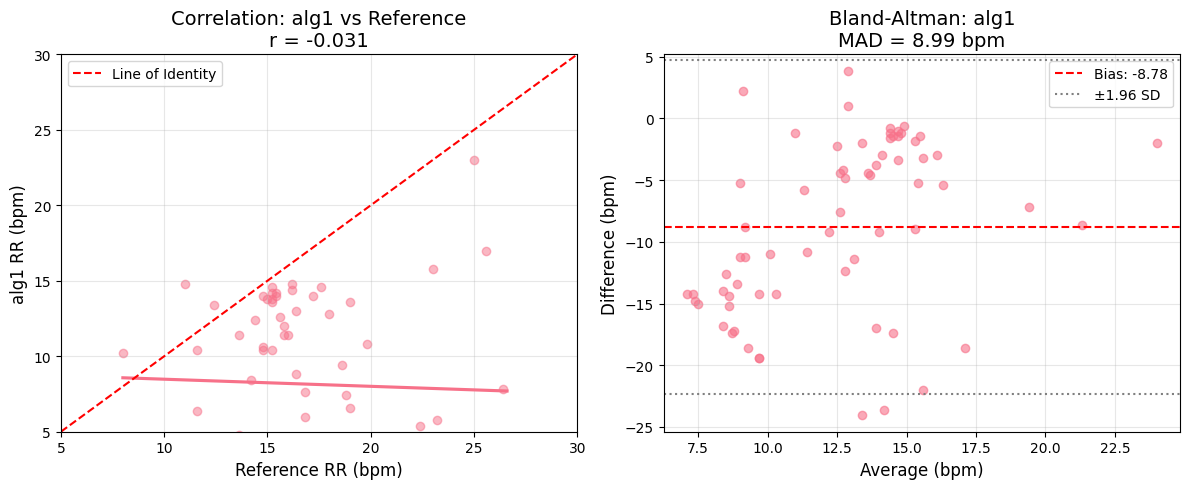


ENHANCED VALIDATION REPORT FOR: ALG2
📊 DATA YIELD & RELIABILITY:
   Valid epochs: 66/67 (98.5%)
   Mean data quality: 100.0%
   Paper benchmark: 95.4% epoch reliability
   ✅ MEETS paper reliability standard

📈 ERROR METRICS:
   Mean Absolute Difference (MAD): 2.08 bpm
   Root Mean Squared Error (RMSE): 3.48 bpm
   Paper benchmark MAD: 0.6 bpm
   ⚠️ Above paper MAD standard

🔗 CORRELATION:
   Pearson Correlation (r): 0.531
   ❌ Weak correlation

🎯 CLINICAL AGREEMENT:
   Agreement < 1 bpm: 53.0%
   Agreement < 2 bpm: 66.7%
   Agreement < 3 bpm: 80.3%
   Paper benchmark: 86% agreement ≤2 bpm
   ⚠️ Below paper agreement standard

⚖️ BIAS ANALYSIS:
   Mean bias: +0.04 bpm
   ✅ Low bias


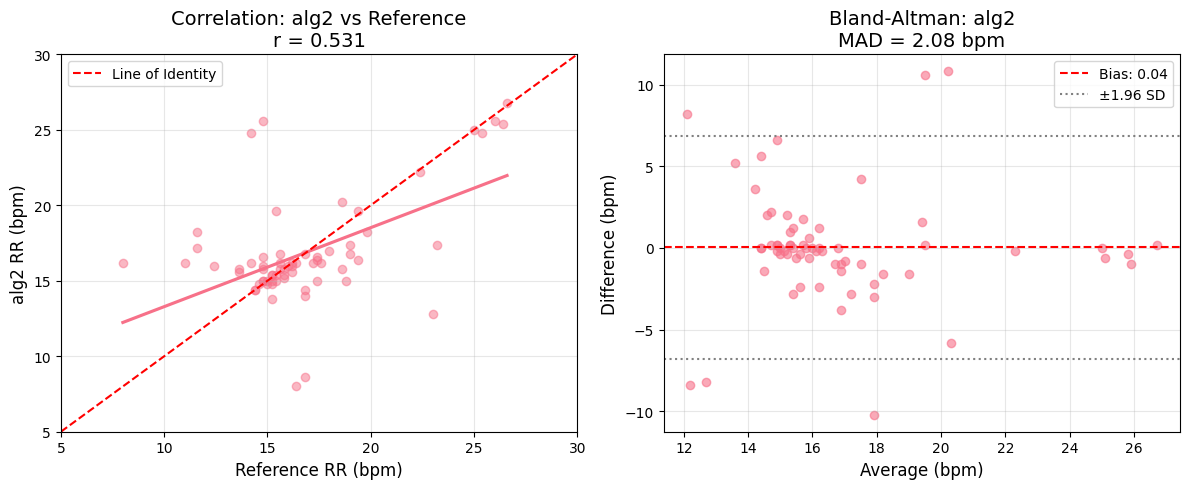

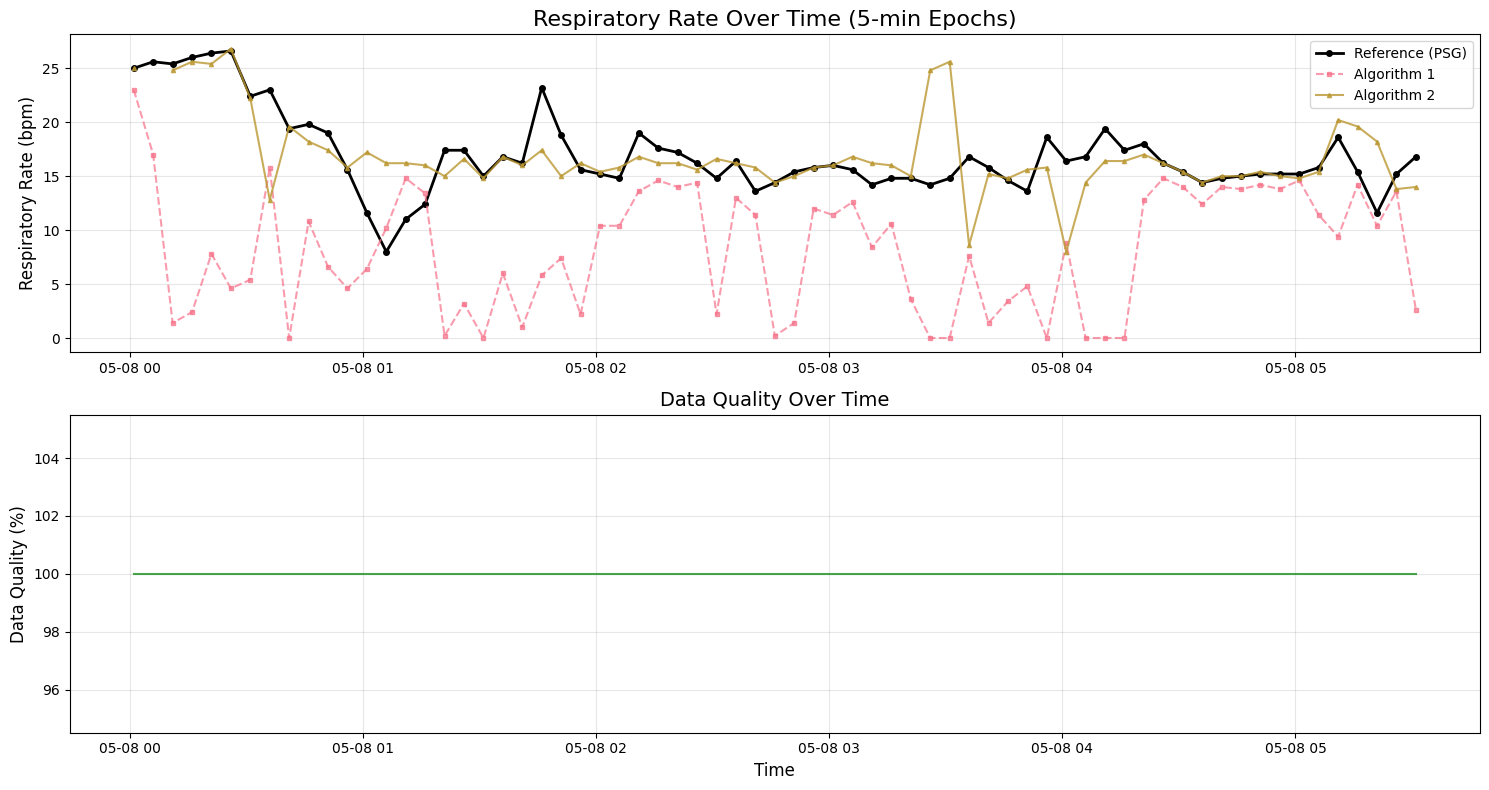


✅ ENHANCED VALIDATION COMPLETE!
📊 Summary: 67 epochs analyzed over 0 days 05:30:00

🎉 Validation complete! Results stored in 'results' variable
   Access results with: results.head()
   Export with: results.to_csv('validation_results.csv')


In [87]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# === ROBUST TIMEZONE HANDLING FROM FRAMEWORK ===

def _safe_total_seconds(time_diff):
    """Safely convert time difference to seconds, handling both pandas and numpy types"""
    if hasattr(time_diff, 'total_seconds'):
        # pandas Timedelta
        return time_diff.total_seconds()
    elif hasattr(time_diff, 'astype'):
        # numpy timedelta64 - convert to seconds
        return float(time_diff / np.timedelta64(1, 's'))
    elif isinstance(time_diff, (int, float)):
        # Already in seconds
        return float(time_diff)
    else:
        # Try to convert to pandas Timedelta first
        try:
            return pd.Timedelta(time_diff).total_seconds()
        except:
            # Last resort - try to extract seconds from string representation
            try:
                # Handle cases like numpy.timedelta64 string representations
                if hasattr(time_diff, '__str__'):
                    time_str = str(time_diff)
                    if 'days' in time_str or 'seconds' in time_str:
                        # Parse formats like "0 days 00:02:30" or "150 seconds"
                        import re
                        days_match = re.search(r'(\d+)\s+days?', time_str)
                        seconds_match = re.search(r'(\d+(?:\.\d+)?)\s+seconds?', time_str)
                        time_match = re.search(r'(\d{2}):(\d{2}):(\d{2}(?:\.\d+)?)', time_str)
                        
                        total_seconds = 0
                        if days_match:
                            total_seconds += int(days_match.group(1)) * 86400
                        if seconds_match:
                            total_seconds += float(seconds_match.group(1))
                        if time_match:
                            hours = int(time_match.group(1))
                            minutes = int(time_match.group(2))
                            seconds = float(time_match.group(3))
                            total_seconds += hours * 3600 + minutes * 60 + seconds
                        
                        return total_seconds
                
                # Final fallback
                return float(time_diff)
            except:
                # If all else fails, return 0
                print(f"Warning: Could not convert time difference {time_diff} to seconds")
                return 0.0

def normalize_timezones(df, target_tz='Asia/Bishkek'):
    """
    Robust timezone normalization that handles various timezone scenarios
    """
    print(f"🌍 Normalizing timezone to {target_tz}...")
    
    # Make a copy to avoid modifying original
    df_normalized = df.copy()
    
    # Ensure timestamp is datetime
    df_normalized['timestamp'] = pd.to_datetime(df_normalized['timestamp'])
    
    # Check current timezone status
    current_tz = df_normalized['timestamp'].dt.tz
    is_tz_aware = current_tz is not None
    
    print(f"   Current timezone: {current_tz}")
    print(f"   Timezone aware: {is_tz_aware}")
    
    try:
        if is_tz_aware:
            if str(current_tz) != target_tz:
                print(f"   Converting from {current_tz} to {target_tz}")
                df_normalized['timestamp'] = df_normalized['timestamp'].dt.tz_convert(target_tz)
            else:
                print(f"   Already in {target_tz}")
        else:
            print(f"   Localizing naive timestamps to {target_tz}")
            df_normalized['timestamp'] = df_normalized['timestamp'].dt.tz_localize(target_tz)
        
        final_tz = df_normalized['timestamp'].dt.tz
        print(f"   ✅ Final timezone: {final_tz}")
        
        # Show sample timestamps
        if len(df_normalized) > 0:
            print(f"   📅 Sample timestamp: {df_normalized['timestamp'].iloc[0]}")
        
        return df_normalized
        
    except Exception as e:
        print(f"   ⚠️ Timezone conversion failed: {e}")
        print(f"   Falling back to original timestamps")
        return df

# --- Step 1: Enhanced Data Preparation ---

def synchronize_and_resample(respeck_df, psg_df, target_hz=50, target_tz='Asia/Bishkek'):
    """
    Enhanced synchronization with robust timezone handling
    """
    print("=" * 60)
    print("STEP 1: ENHANCED DATA SYNCHRONIZATION")
    print("=" * 60)
    
    # Reset index if timestamp is currently the index
    if respeck_df.index.name == 'timestamp':
        respeck_df = respeck_df.reset_index()
    if psg_df.index.name == 'timestamp':
        psg_df = psg_df.reset_index()
    
    print(f"📊 Input data sizes:")
    print(f"   Respeck: {len(respeck_df):,} samples")
    print(f"   PSG: {len(psg_df):,} samples")
    
    # Apply robust timezone normalization
    print(f"\n🔧 RESPECK DATA:")
    respeck_normalized = normalize_timezones(respeck_df, target_tz)
    
    print(f"\n🔧 PSG DATA:")
    psg_normalized = normalize_timezones(psg_df, target_tz)
    
    # Set timestamp as index after normalization
    respeck_normalized.set_index('timestamp', inplace=True)
    psg_normalized.set_index('timestamp', inplace=True)
    
    print(f"\n📅 Time range analysis:")
    respeck_start = respeck_normalized.index.min()
    respeck_end = respeck_normalized.index.max()
    psg_start = psg_normalized.index.min() 
    psg_end = psg_normalized.index.max()
    
    print(f"   Respeck: {respeck_start} to {respeck_end}")
    print(f"   PSG: {psg_start} to {psg_end}")
    
    # Calculate overlap
    overlap_start = max(respeck_start, psg_start)
    overlap_end = min(respeck_end, psg_end)
    overlap_duration = _safe_total_seconds(overlap_end - overlap_start) / 3600  # hours
    
    print(f"   Overlap: {overlap_start} to {overlap_end}")
    print(f"   Duration: {overlap_duration:.2f} hours")
    
    if overlap_duration < 0.1:  # Less than 6 minutes
        print("   ⚠️ WARNING: Very short overlap period!")
    
    # Combine and resample with enhanced error handling
    print(f"\n🔄 Resampling to {target_hz} Hz...")
    
    try:
        # Select only the nasal signal column for PSG
        psg_signal_cols = [col for col in psg_normalized.columns 
                          if any(keyword in col.lower() for keyword in ['nasal', 'resp', 'cannula', 'flow'])]
        
        if not psg_signal_cols:
            raise ValueError("No nasal/respiratory signal column found in PSG data")
        
        psg_signal_col = psg_signal_cols[0]
        print(f"   Using PSG column: '{psg_signal_col}'")
        
        # Combine the dataframes
        combined_df = pd.concat([
            respeck_normalized, 
            psg_normalized[[psg_signal_col]].rename(columns={psg_signal_col: 'Resp nasal'})
        ], axis=1)
        
        print(f"   Combined shape before resampling: {combined_df.shape}")
        
        # Resample to target frequency
        resample_rule = f"{1000/target_hz:.0f}ms"
        print(f"   Resampling rule: {resample_rule}")
        
        resampled_df = combined_df.resample(resample_rule).mean()
        
        # Handle missing data
        initial_nan_count = resampled_df.isna().sum().sum()
        resampled_df.ffill(inplace=True)  # Forward-fill to handle gaps
        resampled_df.dropna(inplace=True)  # Drop any remaining NaNs
        
        final_nan_count = resampled_df.isna().sum().sum()
        print(f"   Handled {initial_nan_count} NaN values, {final_nan_count} remain")
        
        # Separate back into two dataframes
        respeck_cols = [col for col in resampled_df.columns if col != 'Resp nasal']
        final_respeck_df = resampled_df[respeck_cols]
        final_psg_df = resampled_df[['Resp nasal']]
        
        # Verify synchronization
        sync_duration = len(final_respeck_df) / target_hz / 60  # minutes
        print(f"\n✅ Synchronization complete:")
        print(f"   Final aligned samples: {len(final_respeck_df):,}")
        print(f"   Duration: {sync_duration:.2f} minutes ({sync_duration/60:.2f} hours)")
        print(f"   Sampling rate: {target_hz} Hz")
        print(f"   Data quality: {(len(final_respeck_df) / (sync_duration * 60 * target_hz)) * 100:.1f}% complete")
        
        return final_respeck_df, final_psg_df
        
    except Exception as e:
        print(f"❌ Synchronization failed: {e}")
        import traceback
        traceback.print_exc()
        raise

# --- Step 2: Enhanced Reference Calculation ---

def calculate_rr_from_psg(epoch_df, target_hz=50):
    """Enhanced PSG-based RR calculation with better error handling"""
    try:
        if 'Resp nasal' not in epoch_df.columns:
            return np.nan
            
        signal = epoch_df['Resp nasal'].values
        
        # Check signal quality
        if len(signal) < target_hz * 30:  # Less than 30 seconds
            return np.nan
            
        # Remove any remaining NaNs or infs
        signal = signal[~np.isnan(signal)]
        signal = signal[~np.isinf(signal)]
        
        if len(signal) < target_hz * 10:  # Less than 10 seconds of valid data
            return np.nan
        
        # Enhanced bandpass filter for respiratory frequencies
        nyquist = 0.5 * target_hz
        low = 0.05 / nyquist   # 3 bpm minimum
        high = 1.0 / nyquist   # 60 bpm maximum
        
        # Check if filter parameters are valid
        if low >= 1 or high >= 1:
            print(f"⚠️ Invalid filter parameters: low={low}, high={high}")
            return np.nan
            
        b, a = butter(2, [low, high], btype='band')
        filtered_signal = filtfilt(b, a, signal)

        # Adaptive peak detection
        signal_std = np.std(filtered_signal)
        height_threshold = signal_std * 0.3  # More conservative threshold
        min_distance = int(target_hz * 0.8)   # Minimum 0.8 seconds between breaths
        
        peaks, _ = find_peaks(
            filtered_signal, 
            height=height_threshold, 
            distance=min_distance
        )
        
        # Calculate respiratory rate
        duration_min = len(signal) / target_hz / 60
        rr = len(peaks) / duration_min if duration_min > 0 else 0
        
        # Sanity check - physiologically reasonable range
        # if rr < 3 or rr > 60:
        #     return np.nan
            
        return rr
        
    except Exception as e:
        print(f"⚠️ PSG RR calculation failed: {e}")
        return np.nan

# --- Step 3: Enhanced Algorithm Wrappers ---

def calculate_rr_from_getbreaths(epoch_df):
    """Enhanced wrapper with better error handling"""
    try:
        
        # Prepare data for algorithm
        epoch_copy = epoch_df.copy()
        epoch_copy = epoch_copy.reset_index()
        
        # Ensure required columns exist
        if 'breathingSignal' not in epoch_copy.columns:
            print("⚠️ No 'breathingSignal' column found")
            return np.nan
        
        _, stats = getBreathsConservative(epoch_copy, return_dataframe=True)
        
        rr = stats.get('breaths_per_minute', np.nan)
        
        # Sanity check
        # if rr < 3 or rr > 60:
        #     return np.nan
            
        return rr
        
    except Exception as e:
        print(f"⚠️ getBreaths calculation failed: {e}")
        return np.nan

def calculate_rr_from_adaptive(epoch_df):
    """Enhanced wrapper with better error handling"""
    try:
        # Check if algorithm is available
        # Prepare data for algorithm
        epoch_copy = epoch_df.copy()
        epoch_copy = epoch_copy.reset_index()
        
        # Add required columns if missing
        required_cols = ['x', 'y', 'z', 'activityLevel']
        for col in required_cols:
            if col not in epoch_copy.columns:
                epoch_copy[col] = 0
        
        # Ensure breathingSignal exists
        if 'breathingSignal' not in epoch_copy.columns:
            print("⚠️ No 'breathingSignal' column found")
            return np.nan
            
        _, stats = adaptive_breath_detection_hybrid(epoch_copy)
        
        rr = stats.get('breaths_per_minute', np.nan)
        
        # Sanity check
        if rr < 3 or rr > 60:
            return np.nan
            
        return rr
        
    except Exception as e:
        print(f"⚠️ Adaptive calculation failed: {e}")
        return np.nan

# --- Step 4: Enhanced Epoch Analysis ---

def run_epoch_analysis(respeck_df, psg_df, epoch_minutes=5):
    """Enhanced epoch analysis with robust timezone handling"""
    print("\n" + "=" * 60)
    print(f"STEP 2: RUNNING ENHANCED EPOCH ANALYSIS ({epoch_minutes}-min epochs)")
    print("=" * 60)
    
    # Calculate epoch parameters
    epoch_duration = pd.Timedelta(minutes=epoch_minutes)
    target_hz = 50  # Assume 50 Hz from synchronization
    min_samples_per_epoch = int(0.6 * epoch_duration.total_seconds() * target_hz)
    
    print(f"📊 Epoch configuration:")
    print(f"   Duration: {epoch_minutes} minutes")
    print(f"   Minimum samples required: {min_samples_per_epoch:,}")
    print(f"   Expected samples per epoch: {int(epoch_duration.total_seconds() * target_hz):,}")
    
    # Get time range
    start_time = respeck_df.index[0]
    end_time = respeck_df.index[-1]
    
    # Ensure timezone consistency for epoch boundaries
    if hasattr(start_time, 'tz') and start_time.tz is not None:
        # Use timezone-aware epoch boundaries
        epoch_starts = pd.date_range(
            start=start_time, 
            end=end_time, 
            freq=epoch_duration,
            tz=start_time.tz
        )
    else:
        # Use naive epoch boundaries
        epoch_starts = pd.date_range(
            start=start_time, 
            end=end_time, 
            freq=epoch_duration
        )
    
    total_epochs = len(epoch_starts) - 1
    print(f"   Total epochs to process: {total_epochs}")
    print(f"   Time range: {start_time} to {end_time}")
    
    if total_epochs < 1:
        print("❌ Insufficient data for epoch analysis")
        return pd.DataFrame()
    
    results = []
    successful_epochs = 0
    
    for i in tqdm(range(total_epochs), desc="Processing Epochs"):
        epoch_start = epoch_starts[i]
        epoch_end = epoch_starts[i+1]
        
        try:
            # Slice data for the current epoch
            respeck_epoch = respeck_df[epoch_start:epoch_end]
            psg_epoch = psg_df[epoch_start:epoch_end]
            
            # Check for sufficient data
            if len(respeck_epoch) < min_samples_per_epoch or len(psg_epoch) < min_samples_per_epoch:
                continue
            
            # Calculate RR from all sources
            rr_ref = calculate_rr_from_psg(psg_epoch, target_hz)
            rr_alg1 = calculate_rr_from_getbreaths(respeck_epoch.copy())
            rr_alg2 = calculate_rr_from_adaptive(respeck_epoch.copy())
            
            results.append({
                'epoch_number': i + 1,
                'epoch_time': epoch_start,
                'epoch_end': epoch_end,
                'samples_respeck': len(respeck_epoch),
                'samples_psg': len(psg_epoch),
                'RR_ref': rr_ref,
                'RR_alg1': rr_alg1,
                'RR_alg2': rr_alg2,
                'data_quality': min(len(respeck_epoch), len(psg_epoch)) / (epoch_minutes * 60 * target_hz)
            })
            
            if not np.isnan(rr_ref):
                successful_epochs += 1
                
        except Exception as e:
            print(f"⚠️ Error processing epoch {i+1}: {e}")
            continue
    
    results_df = pd.DataFrame(results)
    
    print(f"\n📈 Analysis Results:")
    print(f"   Total epochs processed: {len(results_df)}")
    print(f"   Epochs with valid reference: {successful_epochs}")
    print(f"   Success rate: {successful_epochs/total_epochs*100:.1f}%")
    
    if len(results_df) > 0:
        print(f"   Mean data quality: {results_df['data_quality'].mean()*100:.1f}%")
        
        # Show RR statistics
        for col in ['RR_ref', 'RR_alg1', 'RR_alg2']:
            if col in results_df.columns:
                valid_values = results_df[col].dropna()
                if len(valid_values) > 0:
                    print(f"   {col}: {len(valid_values)} valid, mean={valid_values.mean():.1f}±{valid_values.std():.1f} bpm")
    
    return results_df

# --- Rest of the analysis functions remain the same ---

def plot_bland_altman(rr_ref, rr_alg, alg_name):
    """Generates and displays a Bland-Altman plot."""
    diff = rr_alg - rr_ref
    avg = (rr_alg + rr_ref) / 2
    
    mean_diff = np.mean(diff)
    std_diff = np.std(diff)
    loa_upper = mean_diff + 1.96 * std_diff
    loa_lower = mean_diff - 1.96 * std_diff
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=avg, y=diff, alpha=0.6)
    plt.axhline(mean_diff, color='red', linestyle='--', label=f'Mean Bias: {mean_diff:.2f}')
    plt.axhline(loa_upper, color='gray', linestyle=':', label=f'Upper LoA: {loa_upper:.2f}')
    plt.axhline(loa_lower, color='gray', linestyle=':', label=f'Lower LoA: {loa_lower:.2f}')
    
    plt.title(f'Bland-Altman Plot: {alg_name} vs. Reference', fontsize=16)
    plt.xlabel('Average of Measurements (BPM)', fontsize=12)
    plt.ylabel('Difference between Measurements (BPM)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

def generate_report(results_df, alg_col, ref_col='RR_ref'):
    """Enhanced report generation with additional metrics"""
    alg_name = alg_col.replace('RR_', '')
    print("\n" + "="*60)
    print(f"ENHANCED VALIDATION REPORT FOR: {alg_name.upper()}")
    print("="*60)
    
    # Filter out NaNs for this specific comparison
    comparison_df = results_df[[ref_col, alg_col, 'data_quality']].dropna()
    
    if len(comparison_df) == 0:
        print("❌ No valid epochs to compare. Cannot generate report.")
        return
    
    rr_ref = comparison_df[ref_col]
    rr_alg = comparison_df[alg_col]
    data_quality = comparison_df['data_quality']

    # 1. Enhanced Data Yield Analysis
    total_epochs = len(results_df)
    valid_epochs = len(comparison_df)
    yield_percent = (valid_epochs / total_epochs) * 100
    
    print(f"📊 DATA YIELD & RELIABILITY:")
    print(f"   Valid epochs: {valid_epochs}/{total_epochs} ({yield_percent:.1f}%)")
    print(f"   Mean data quality: {data_quality.mean()*100:.1f}%")
    print(f"   Paper benchmark: 95.4% epoch reliability")
    
    if yield_percent >= 95:
        print("   ✅ MEETS paper reliability standard")
    else:
        print("   ⚠️ Below paper reliability standard")
    
    # 2. Enhanced Error Metrics
    mad = np.mean(np.abs(rr_alg - rr_ref))
    rmse = np.sqrt(np.mean((rr_alg - rr_ref)**2))
    
    print(f"\n📈 ERROR METRICS:")
    print(f"   Mean Absolute Difference (MAD): {mad:.2f} bpm")
    print(f"   Root Mean Squared Error (RMSE): {rmse:.2f} bpm")
    print(f"   Paper benchmark MAD: 0.6 bpm")
    
    if mad <= 0.6:
        print("   ✅ MEETS paper MAD standard")
    else:
        print("   ⚠️ Above paper MAD standard")
    
    # 3. Correlation
    correlation = rr_alg.corr(rr_ref)
    print(f"\n🔗 CORRELATION:")
    print(f"   Pearson Correlation (r): {correlation:.3f}")
    
    if correlation >= 0.8:
        print("   ✅ Strong correlation")
    elif correlation >= 0.6:
        print("   ⚠️ Moderate correlation")
    else:
        print("   ❌ Weak correlation")

    # 4. Enhanced Clinical Agreement
    diffs = np.abs(rr_alg - rr_ref)
    agree_lt1 = (np.sum(diffs < 1) / len(diffs)) * 100
    agree_lt2 = (np.sum(diffs < 2) / len(diffs)) * 100
    agree_lt3 = (np.sum(diffs < 3) / len(diffs)) * 100
    
    print(f"\n🎯 CLINICAL AGREEMENT:")
    print(f"   Agreement < 1 bpm: {agree_lt1:.1f}%")
    print(f"   Agreement < 2 bpm: {agree_lt2:.1f}%")
    print(f"   Agreement < 3 bpm: {agree_lt3:.1f}%")
    print(f"   Paper benchmark: 86% agreement ≤2 bpm")
    
    if agree_lt2 >= 86:
        print("   ✅ MEETS paper agreement standard")
    else:
        print("   ⚠️ Below paper agreement standard")
    
    # 5. Bias Analysis
    bias = np.mean(rr_alg - rr_ref)
    print(f"\n⚖️ BIAS ANALYSIS:")
    print(f"   Mean bias: {bias:+.2f} bpm")
    if abs(bias) < 0.5:
        print("   ✅ Low bias")
    elif abs(bias) < 1.0:
        print("   ⚠️ Moderate bias")
    else:
        print("   ❌ High bias")
    
    print("="*60)

    # Enhanced visualizations
    # 1. Correlation Plot
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.regplot(x=rr_ref, y=rr_alg, ci=None, scatter_kws={'alpha':0.5})
    plt.plot([5, 30], [5, 30], color='red', linestyle='--', label='Line of Identity')
    plt.title(f'Correlation: {alg_name} vs Reference\nr = {correlation:.3f}', fontsize=14)
    plt.xlabel('Reference RR (bpm)', fontsize=12)
    plt.ylabel(f'{alg_name} RR (bpm)', fontsize=12)
    plt.xlim(5, 30); plt.ylim(5, 30)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Bland-Altman Plot
    plt.subplot(1, 2, 2)
    diff = rr_alg - rr_ref
    avg = (rr_alg + rr_ref) / 2
    mean_diff = np.mean(diff)
    std_diff = np.std(diff)
    
    plt.scatter(avg, diff, alpha=0.6)
    plt.axhline(mean_diff, color='red', linestyle='--', label=f'Bias: {mean_diff:.2f}')
    plt.axhline(mean_diff + 1.96*std_diff, color='gray', linestyle=':', label='±1.96 SD')
    plt.axhline(mean_diff - 1.96*std_diff, color='gray', linestyle=':')
    plt.title(f'Bland-Altman: {alg_name}\nMAD = {mad:.2f} bpm', fontsize=14)
    plt.xlabel('Average (bpm)', fontsize=12)
    plt.ylabel('Difference (bpm)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# --- Enhanced Main Execution ---

def run_enhanced_validation(respeck_df, psg_df, epoch_minutes=5, target_tz='Asia/Bishkek'):
    """
    Complete enhanced validation pipeline
    """
    print("🚀 ENHANCED BREATH DETECTION VALIDATION")
    print("🔬 Combining practical approach with robust timezone handling")
    print("=" * 80)
    
    try:
        # 1. Enhanced synchronization
        respeck_sync_df, psg_sync_df = synchronize_and_resample(
            respeck_df, psg_df, target_tz=target_tz
        )
        
        # 2. Enhanced epoch analysis
        results_df = run_epoch_analysis(respeck_sync_df, psg_sync_df, epoch_minutes)
        
        if len(results_df) == 0:
            print("❌ No valid epochs generated. Check data quality and synchronization.")
            return None
        
        print("\n" + "=" * 60)
        print("RESULTS SUMMARY")
        print("=" * 60)
        print(results_df[['epoch_time', 'RR_ref', 'RR_alg1', 'RR_alg2']].head(10))
        
        # 3. Enhanced validation reports
        if 'RR_alg1' in results_df.columns:
            generate_report(results_df, 'RR_alg1', 'RR_ref')
        
        if 'RR_alg2' in results_df.columns:
            generate_report(results_df, 'RR_alg2', 'RR_ref')
        
        # 4. Time series visualization
        plt.figure(figsize=(15, 8))
        
        plt.subplot(2, 1, 1)
        plt.plot(results_df['epoch_time'], results_df['RR_ref'], 'o-', 
                label='Reference (PSG)', color='black', linewidth=2, markersize=4)
        if 'RR_alg1' in results_df.columns:
            plt.plot(results_df['epoch_time'], results_df['RR_alg1'], 's--', 
                    label="Algorithm 1", alpha=0.7, markersize=3)
        if 'RR_alg2' in results_df.columns:
            plt.plot(results_df['epoch_time'], results_df['RR_alg2'], '^-', 
                    label='Algorithm 2', alpha=0.8, markersize=3)
        
        plt.title(f'Respiratory Rate Over Time ({epoch_minutes}-min Epochs)', fontsize=16)
        plt.ylabel('Respiratory Rate (bpm)', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 1, 2)
        plt.plot(results_df['epoch_time'], results_df['data_quality']*100, 'g-', alpha=0.7)
        plt.title('Data Quality Over Time', fontsize=14)
        plt.ylabel('Data Quality (%)', fontsize=12)
        plt.xlabel('Time', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n✅ ENHANCED VALIDATION COMPLETE!")
        print(f"📊 Summary: {len(results_df)} epochs analyzed over {results_df['epoch_time'].iloc[-1] - results_df['epoch_time'].iloc[0]}")
        
        return results_df
        
    except Exception as e:
        print(f"❌ Enhanced validation failed: {e}")
        import traceback
        traceback.print_exc()
        return None

# === USAGE EXAMPLE ===
if __name__ == "__main__":
    """
    Run the enhanced validation with your data
    """
    
    # Ensure your dataframes are prepared
    if 'respeck_df' not in globals() or 'psg_df' not in globals():
        print("❌ Please ensure respeck_df and psg_df are loaded")
    else:
        # Reset index if needed
        if hasattr(respeck_df, 'index') and respeck_df.index.name == 'timestamp':
            respeck_df = respeck_df.reset_index()
        if hasattr(psg_df, 'index') and psg_df.index.name == 'timestamp':
            psg_df = psg_df.reset_index()
        
        # Run enhanced validation
        results = run_enhanced_validation(
            respeck_df, 
            psg_df, 
            epoch_minutes=5,
            target_tz='Asia/Bishkek'  # Use your actual timezone
        )
        
        if results is not None:
            print(f"\n🎉 Validation complete! Results stored in 'results' variable")
            print(f"   Access results with: results.head()")
            print(f"   Export with: results.to_csv('validation_results.csv')")